# Data Understanding & Exploratory Data Analysis (EDA)

**Project**: DiaMetric-CDC
**Dataset**: 2015 CDC BRFSS (253,680 records)

---

## Table of Contents

```text
├── 1. Introduction
│   ├── 1.1 Scope and Objectives
│   └── 1.2 Exploratory Hypotheses
│
├── 2. Environment Setup & Tool Integration
│
├── 3. Data Ingestion & Metadata Mapping
│   ├── 3.1 Data Loading & Integrity Check
│   ├── 3.2 Semantic Labeling
│   └── 3.3 Feature Taxonomy
│
├── 4. Data Quality & Integrity Audit
│   ├── 4.1 Missingness & Duplicates
│   ├── 4.2 Placeholder & Logic Audit
│   ├── 4.3 Distribution & Outliers (Normality Tests)
│   └── 4.4 Logical Consistency Audit (Sanity Check)
│
├── 5. Statistical Profiling & Visualization
│   ├── 5.1 Target Distribution (Class Balance)
│   ├── 5.2 Categorical Risks (Cramer's V)
│   ├── 5.3 BMI Analysis (KDE & Clinical Buckets)
│   ├── 5.4 Non-linear Trend Analysis (LOWESS)
│   ├── 5.5 Socio-economic Gradient Analysis
│   └── 5.6 Demographic Fairness & Bias Audit
│
├── 6. Advanced Interaction Analysis
│   └── 6.1 Age-BMI Synergy Heatmap
│
├── 7. Multivariate Power Analysis
│   ├── 7.1 PCA & Dimensionality Audit
│   ├── 7.2 Multicollinearity (VIF)
│   └── 7.3 Clustering Tendency (Hopkins Statistic)
│
├── 8. Feature Utility Synthesis
├── 9. Deep Dive: Pre-diabetes Analysis
├── 10. Ethical Considerations & Data Bias
│
├── 11. Phase 2 Strategy: Data Preparation Roadmap
│   ├── 11.1 Target Optimization & Balancing
│   ├── 11.2 Feature Engineering & Refinement
│   └── 11.3 Unsupervised Clustering Pipeline
│
└── 12. Research Limitations & Ethical Constraints
    ├── 12.1 Temporal & Causal Constraints
    ├── 12.2 Systematic Reporting Bias
    ├── 12.3 Selection & Representation Constraints
    └── 12.4 Label Noise & Diagnostic Ambiguity

## 1. Introduction

### 1.1 Scope and Objectives

This phase executes a systematic data understanding of the 2015 CDC BRFSS dataset to evaluate its utility for classification and unsupervised clustering. As a cross-sectional study, the analysis identifies statistical associations rather than causal mechanisms. The primary objective is to ensure data fidelity and characterize feature-target dynamics.

**Analytical Focus:**
- **Outcome Structural Audit**: Evaluation of the trinary `Diabetes_012` distribution to support binary reformulation.
- **Data Quality Audit**: Identification of missingness, clinical outliers, and systematic reporting biases.
- **Feature Profiling**: Triangulation of metabolic, socio-economic, and lifestyle indicators to quantify risk associations.
- **Unsupervised Pattern Discovery**: Assessment of the geometric structure of lifestyle indicators to identify latent population segments.

### 1.2 Exploratory Hypotheses

- **H1 (Non-linear Risk Escalation)**: BMI exhibits a non-linear dose-response relationship, with risk accelerating significantly beyond the clinical obesity threshold (BMI ≥ 30).
- **H2 (Metabolic Clustering)**: Hypertension and hypercholesterolemia serve as primary diagnostic anchors, reflecting clustered physiological risk.
- **H3 (Socio-economic Gradient)**: Lower income and education levels correlate with increased disease prevalence, indicating strong social determinants of health.
- **H4 (Subjective Proxy)**: Self-reported General Health (`GenHlth`) functions as a high-fidelity proxy for latent physiological burden and comorbidity.

## 2. Environment Setup & Tool Integration

This section initializes the analytical workspace and integrates a specialized suite of tools for data profiling and statistical auditing. The environment is configured to prioritize reproducibility and clarity in large-scale data processing.

**Technical Stack Overview:**
* **Statistical Diagnostics**: Utilizing `scipy.stats` and `VIF` to identify distributional anomalies and multicollinearity.
* **Feature Dependency**: Leveraging `Mutual Information` and `Random Forest` heuristics to quantify initial feature-target relationships.
* **Dimensionality & Scaling**: Integrating `PCA` and `StandardScaler` to evaluate the geometric structure of the feature space and potential variance compression.

In [44]:
# --- 2. Environment Setup & Tool Integration ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import re
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from IPython.display import display

# --- Global Configurations ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
warnings.filterwarnings('ignore')

# --- Aesthetic & Display Standardization ---
# Critical: Initialize the backend BEFORE applying any monkeypatches
%matplotlib inline
sns.set(style="whitegrid", context="notebook", palette="viridis")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# --- Automated Plot Export System (Engineering Standard) ---

class PlotExporter:
    """
    Automated utility to intercept matplotlib show calls and export figures.
    Designed for 2015 CDC BRFSS dataset visualization tracking.
    """
    def __init__(self, base_dir='outputs', sub_dir='data_understanding'):
        self.save_path = os.path.join(base_dir, sub_dir)
        self._counter = 1

        # Ensure target directory exists for data understanding phase
        if not os.path.exists(self.save_path):
            os.makedirs(self.save_path)
            print(f"Directory initialized: {self.save_path}")

    def _clean_filename(self, text):
        """Sanitizes plot titles for filesystem compatibility."""
        if not text:
            return "untitled_plot"
        clean_text = re.sub(r'[^\w\s-]', '', text).strip().lower()
        return re.sub(r'[-\s]+', '_', clean_text)

    def export(self, *args, **kwargs):
        """
        Captures current figure, generates metadata-driven filename,
        and saves at 300 DPI before rendering.
        """
        fig = plt.gcf()
        axes = fig.get_axes()

        # Extract metadata from plot title if available
        plot_title = axes[0].get_title() if axes else ""
        filename_base = self._clean_filename(plot_title)
        filename = f"{self._counter:02d}_{filename_base}.png"
        full_path = os.path.join(self.save_path, filename)

        fig.savefig(full_path, bbox_inches='tight', dpi=300)
        self._counter += 1

        # Use the standard plotting closure to avoid recursion
        return plt.orig_show(*args, **kwargs)

# --- Hook Implementation ---
# Store the original show function in the plt namespace for persistence
if not hasattr(plt, 'orig_show'):
    plt.orig_show = plt.show

# Instantiate exporter for CDC dataset profiling
exporter = PlotExporter()

def wrapped_show(*args, **kwargs):
    """Function wrapper to satisfy Matplotlib's signature requirements."""
    return exporter.export(*args, **kwargs)

# Apply the hook using a standard function instead of a bound method
plt.show = wrapped_show

print(f"Environment setup complete. (Global Seed: {RANDOM_STATE})")
print(f"Global Plot Hook: Active. Figures will auto-save to 'outputs/data_understanding/'.")

Environment setup complete. (Global Seed: 42)
Global Plot Hook: Active. Figures will auto-save to 'outputs/data_understanding/'.


### 3.1 Data Loading & Integrity Check

This section executes the primary ingestion of the CDC health indicators and implements defensive validation protocols. By integrating robust error handling and hard assertions, the process ensures that the raw data structure aligns with official metadata standards, mitigating risks of downstream bias caused by incomplete or corrupted datasets.

**Key Technical Priorities:**
* **Defensive Ingestion**: Utilizing `try-except` blocks to handle file path variations and environment-specific errors.
* **Structural Verification**: Asserting a fixed shape (253,680 rows, 22 columns) to validate that the complete sample population is loaded.
* **Target Distribution Snapshot**: Providing an immediate baseline of the `Diabetes_012` labels to confirm the trinary nature of the raw data and justify subsequent binary alignment.

In [45]:
# --- 3.1 Data Loading ---
file_path = 'data/raw/CDC Diabetes Dataset.csv'

try:
    df = pd.read_csv(file_path)

    # Audit: Validate dataset size matches metadata (253,680 records, 22 columns)
    assert df.shape == (253680, 22), f"Integrity Mismatch: Detected {df.shape}"

    print(f"✅ Dataset loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns.")

    # Immediate verification of the target label distribution
    print("\nInitial Target Distribution (Original Classes):")
    display(df['Diabetes_012'].value_counts(normalize=True).to_frame('Proportion'))

except FileNotFoundError:
    print(f"❌ Error: File not found at '{file_path}'. Check directory structure.")
    df = pd.DataFrame()
except AssertionError as e:
    print(f"⚠️ {e}")

✅ Dataset loaded successfully: 253680 rows, 22 columns.

Initial Target Distribution (Original Classes):


,Proportion
Diabetes_012,
0.000,0.842
2.000,0.139
1.000,0.018


#### 3.1.1 Observations & Initial Diagnostics
* **Schema Conflict Confirmed**: The baseline audit of `Diabetes_012` confirms a three-tier classification. This validates the initial hypothesis regarding the architectural gap between the raw dataset and the project's binary requirement.
* **Imbalance Warning**: Class 1.0 (Pre-diabetes) represents only ~1.8% of the total population. This extreme sparsity justifies the strategic decision to merge it into a single "At-Risk" category and signals the need for class-weighting or sampling techniques in the modeling phase.

### 3.2 Metadata Mapping & Semantic Labeling

This section implements a comprehensive mapping schema based on the official variable definitions to translate encoded integers into meaningful clinical and socio-economic labels. This semantic alignment is critical for maintaining context during exploratory visualizations and statistical profiling.

**Mapping Scope:**
* **Target Alignment**: Mapping for both the original `Diabetes_012` and the project-required `Diabetes_binary`.
* **Ordinal Scales**: Defining `GenHlth`, `Education`, `Income`, and `Age` categories.
* **Binary Indicators**: Translating 0/1 codes into descriptive states (e.g., Yes/No, Male/Female) for physiological and lifestyle features.

In [46]:
# --- 3.2 Metadata Mapping based on CDC Definitions ---

label_maps = {
    # Target Variables
    'Diabetes_012': {0: 'Healthy', 1: 'Pre-diabetes', 2: 'Diabetes'},
    'Diabetes_binary': {0: 'No Diabetes', 1: 'Pre-diabetic/Diabetic'},

    # Binary Health & Lifestyle Features
    'HighBP': {0: 'No High BP', 1: 'High BP'},
    'HighChol': {0: 'No High Chol', 1: 'High Chol'},
    'CholCheck': {0: 'No Check (5yrs)', 1: 'Checked (5yrs)'},
    'Smoker': {0: 'No', 1: 'Yes'},
    'Stroke': {0: 'No', 1: 'Yes'},
    'HeartDiseaseorAttack': {0: 'No', 1: 'Yes'},
    'PhysActivity': {0: 'No', 1: 'Yes'},
    'Fruits': {0: 'No', 1: 'Yes'},
    'Veggies': {0: 'No', 1: 'Yes'},
    'HvyAlcoholConsump': {0: 'No', 1: 'Yes'},
    'AnyHealthcare': {0: 'No', 1: 'Yes'},
    'NoDocbcCost': {0: 'No', 1: 'Yes'},
    'DiffWalk': {0: 'No', 1: 'Yes'},
    'Sex': {0: 'Female', 1: 'Male'},

    # Ordinal Features
    'GenHlth': {1: 'Excellent', 2: 'Very Good', 3: 'Good', 4: 'Fair', 5: 'Poor'},
    'Education': {
        1: 'Never/Kindergarten', 2: 'Elementary', 3: 'Some HS',
        4: 'HS Grad', 5: 'Some College', 6: 'College Grad'
    },
    'Income': {
        1: '<$10k', 2: '$10k-15k', 3: '$15k-20k', 4: '$20k-25k',
        5: '$25k-35k', 6: '$35k-50k', 7: '$50k-75k', 8: '>$75k'
    },
    'Age': {
        1: '18-24', 2: '25-29', 3: '30-34', 4: '35-39', 5: '40-44',
        6: '45-49', 7: '50-54', 8: '55-59', 9: '60-64', 10: '65-69',
        11: '70-74', 12: '75-79', 13: '80+'
    }
}

print("✅ Comprehensive metadata mappings defined according to CDC documentation.")

✅ Comprehensive metadata mappings defined according to CDC documentation.


### 3.3 Feature Taxonomy & Statistical Summary

This section systematically categorizes the 21 predictors into binary, ordinal, and continuous types based on their measurement scales and mathematical properties. This taxonomy serves as the logical framework for selecting appropriate statistical methodologies and diagnostic visualizations.

**Taxonomy Rationale:**
* **Binary Features**: Evaluated via frequency distributions and proportional density to understand lifestyle prevalence.
* **Ordinal Features**: Structured to preserve hierarchical rank (e.g., Income, Education) for non-linear correlation and trend analysis.
* **Continuous Features**: Assessed for central tendency, variance, and the detection of physiological outliers in variables like BMI.

The synthesized summary table provides a baseline audit of variable cardinality and ranges, ensuring strict alignment with the theoretical bounds defined in the official CDC metadata.

In [47]:
# --- 3.3 Feature Classification & Taxonomy Summary ---

# Explicitly define feature groups for specialized downstream analysis
target = 'Diabetes_binary' if 'Diabetes_binary' in df.columns else 'Diabetes_012'

binary_features = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
    'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
    'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex'
]

ordinal_features = ['GenHlth', 'Age', 'Education', 'Income']

continuous_features = ['BMI', 'MentHlth', 'PhysHlth']

# Generate structured summary for data auditing
summary_list = []

for col in df.columns:
    if col == target:
        feat_type = 'Target'
    elif col in binary_features:
        feat_type = 'Binary'
    elif col in ordinal_features:
        feat_type = 'Ordinal'
    elif col in continuous_features:
        feat_type = 'Continuous'
    else:
        feat_type = 'Unclassified'

    summary_list.append({
        'Feature': col,
        'Type': feat_type,
        'Unique': df[col].nunique(),
        'Min': df[col].min(),
        'Max': df[col].max(),
        'Dtype': df[col].dtype
    })

# Render taxonomy summary
summary_df = pd.DataFrame(summary_list)
print("Variable Taxonomy & Range Audit:")
display(summary_df)

Variable Taxonomy & Range Audit:


,Feature,Type,Unique,Min,Max,Dtype
0,Diabetes_012,Target,3,0.000,2.000,float64
1,HighBP,Binary,2,0.000,1.000,float64
2,HighChol,Binary,2,0.000,1.000,float64
3,CholCheck,Binary,2,0.000,1.000,float64
4,BMI,Continuous,84,12.000,98.000,float64
5,Smoker,Binary,2,0.000,1.000,float64
6,Stroke,Binary,2,0.000,1.000,float64
7,HeartDiseaseorAttack,Binary,2,0.000,1.000,float64
8,PhysActivity,Binary,2,0.000,1.000,float64
9,Fruits,Binary,2,0.000,1.000,float64


#### 3.3.1 Rationale for Feature Taxonomy
* **Ordinal Handling**: Although `Age` and `Income` are stored as integers, they represent categorized buckets rather than continuous measurements. Defining them as "Ordinal" ensures that subsequent non-parametric tests (e.g., Spearman’s Rank Correlation) are applied correctly.
* **Physiological vs. Behavioral Split**: `BMI` is identified as the primary continuous physiological metric. Distinguishing this from self-reported health days (`MentHlth`, `PhysHlth`) allows for specialized outlier detection and distribution modeling specific to biometric data.

## 4. Integrity & Quality Audit

### 4.1 Missing Values and Duplicates

**Rationale**: This section quantifies the structural integrity of the dataset. While missing values can introduce systematic bias, duplicate records in large-scale survey data may stem from either clerical redundancies or the convergence of identical physiological profiles among respondents (given the discrete nature of the features). Quantifying these metrics is essential for determining the subsequent data-handling strategy.

In [48]:
# --- 4.1 Missing Values & Redundancy Audit ---

if not df.empty:
    # 1. Missing Value Audit
    missing_count = df.isnull().sum().sum()

    # 2. Duplicate Row Audit
    duplicate_count = df.duplicated().sum()
    duplicate_pct = (duplicate_count / len(df)) * 100

    print("Data Integrity Audit Results:")
    print("-" * 30)
    print(f"Total Missing Values : {missing_count}")
    print(f"Duplicate Records    : {duplicate_count}")
    print(f"Duplicate Percentage : {duplicate_pct:.2f}%")
    print("-" * 30)

Data Integrity Audit Results:
------------------------------
Total Missing Values : 0
Duplicate Records    : 23899
Duplicate Percentage : 9.42%
------------------------------


#### 4.1.1 Observations & Critical Reflection

* **Structural Integrity**: The audit confirms zero missing values, aligning with official documentation. This high-fidelity environment provides a robust foundation for predictive modeling without the bias introduced by imputation.
* **The Granularity Paradox**: A 9.42% duplicate rate was detected. Given the massive sample size (N ≈ 253,680) and discrete feature space, this redundancy is interpreted as **profile convergence** (identical health archetypes) rather than technical error.
* **Leakage Risk Audit**: While duplicates reflect real population density, retaining them during the split phase poses a risk of **data leakage**. Identical records appearing in both training and testing sets could yield deceptive, inflated performance metrics.
* **Recommended Strategy**: It is proposed to **deduplicate** the dataset while mapping original frequencies to a **Sample_Weight** feature. This approach is recommended to preserve population representation while ensuring a rigorous, "unseen" evaluation environment.

### 4.2 Frequency Audit (Placeholder Check)

**Rationale**: This section scrutinizes ordinal variables (`Age`, `Education`, `Income`) for the presence of specific placeholders. CDC health surveys historically utilize codes like `77` (Don't Know) or `99` (Refused) for non-responses. If untreated, these high-integer placeholders are erroneously processed as valid continuous data, distorting statistical distributions and model gradients.

**Key Technical Priorities:**
* **Boundary Scanning**: Validating that ordinal indices do not exceed the categorical limits defined by the official codebook.
* **Non-response Verification**: Searching for sentinel values (77/99) to determine if additional cleaning or re-encoding is necessary for feature consistency.

In [49]:
# --- 4.2 Placeholder & Boundary Audit ---

if not df.empty:
    # Defined placeholders in CDC BRFSS: 77 (Don't know), 99 (Refused)
    sentinel_values = [77, 99]
    audit_cols = ['Age', 'Education', 'Income']
    audit_results = []

    for col in audit_cols:
        if col in df.columns:
            vals = df[col].unique()
            # Identify any value present in the column that matches sentinel list
            found_placeholders = [v for v in sentinel_values if v in vals]

            audit_results.append({
                'Feature': col,
                'Min': df[col].min(),
                'Max': df[col].max(),
                'Placeholders Found': found_placeholders if found_placeholders else "None"
            })

    # Display as a clean summary table
    audit_summary = pd.DataFrame(audit_results)
    print("Ordinal Scale Integrity Audit:")
    display(audit_summary)

Ordinal Scale Integrity Audit:


,Feature,Min,Max,Placeholders Found
0,Age,1.000,13.000,None
1,Education,1.000,6.000,None
2,Income,1.000,8.000,None


#### 4.2.1 Observations & Critical Reflection

* **Scale Consistency**: The audit confirms that `Age`, `Education`, and `Income` follow their respective 13-point, 6-point, and 8-point scales perfectly. No values fall outside the documented range.
* **Clean Sentinel Check**: The absence of `77` and `99` codes indicates that this dataset is a curated version where non-responses have likely been pre-filtered.
* **Analytic Readiness**: With no high-leverage placeholders detected, these ordinal features are statistically "ready" for correlation analysis without further re-coding.

### 4.3 Integrated Statistical Distribution & Outlier Audit

**Rationale**: This section audits physiological indicators (BMI, MentHlth, PhysHlth) by synthesizing IQR-based outlier detection with D'Agostino’s $K^2$ tests. These diagnostics facilitate evidence-based feature scaling and ensure numerical stability.

**Key Technical Priorities:**
* **Distributional Audit**: Evaluating normality via D'Agostino’s $K^2$, skewness, and kurtosis to determine feature behavior.
* **Outlier Diagnosis**: Applying a 1.5 × IQR threshold to isolate clinical extremes while maintaining robustness against non-normal variances.
* **Scaling Optimization**: Recommending RobustScaler (Median/IQR) for non-Gaussian features to mitigate the impact of heavy-tailed distributions on downstream estimators.

Comprehensive Statistical Distribution & Outlier Audit Summary:


,Feature,Outliers (IQR),Outlier (%),Lower Bound (IQR),Upper Bound (IQR),Skewness,Kurtosis,K2-Stat,p-value,Distribution,Scaling Strategy
0,BMI,9847,3.88%,13.50,41.50,2.122,10.997,126255.72,0.00e+00,Non-Normal,RobustScaler (Median/IQR)
1,MentHlth,36208,14.27%,-3.00,5.00,2.721,6.442,137190.86,0.00e+00,Non-Normal,RobustScaler (Median/IQR)
2,PhysHlth,40949,16.14%,-4.50,7.50,2.207,3.496,104008.52,0.00e+00,Non-Normal,RobustScaler (Median/IQR)


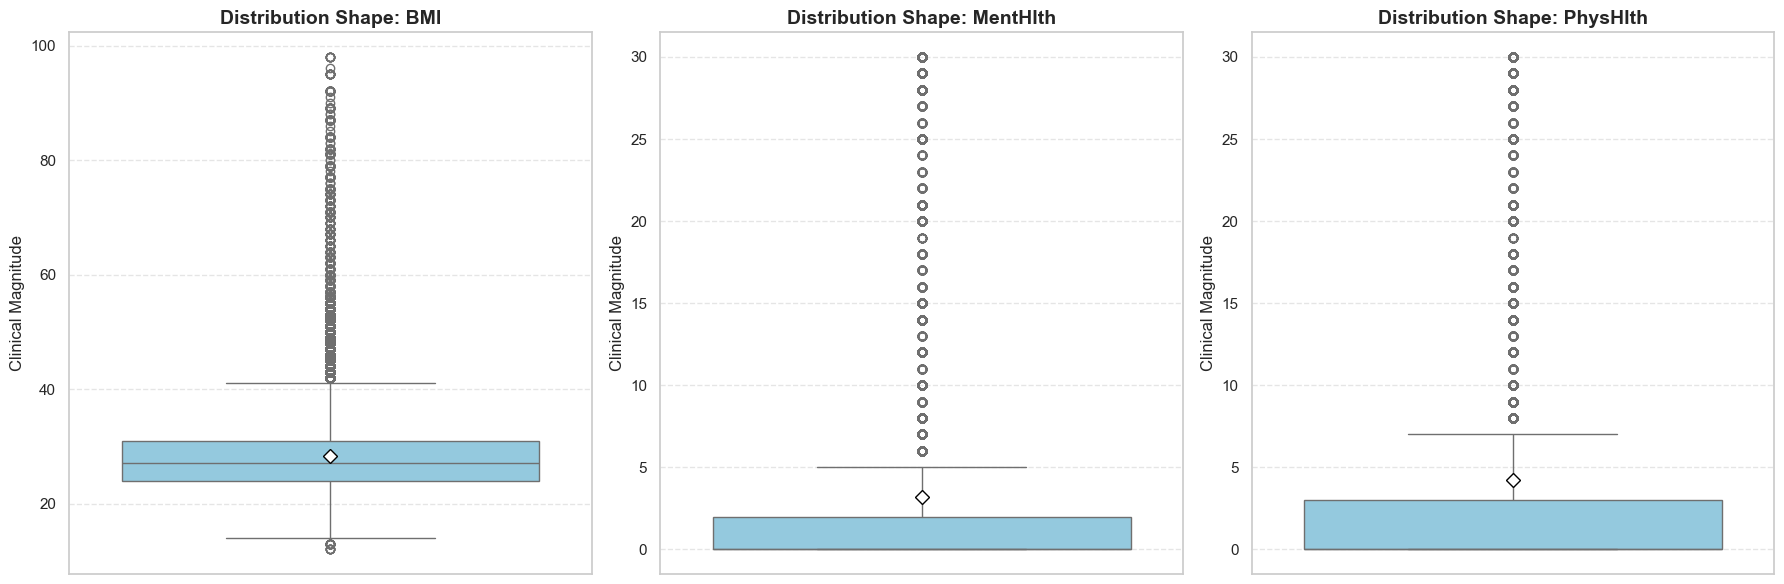

In [50]:
# --- 4.3 Integrated Statistical Distribution & Outlier Audit ---

if not df.empty:
    from scipy.stats import normaltest

    dist_audit_results = []

    # 1. Quantitative Assessment: Statistical Moments, Normality, and Robust Outlier Screening
    for col in continuous_features:
        if col in df.columns:
            # Outlier Detection (IQR-Based Method, Robust to Non-Normality)
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
            outlier_count = outlier_mask.sum()
            outlier_pct = (outlier_count / len(df)) * 100

            # Distributional Moments & Normality Analysis
            # D'Agostino's K^2 Test: Null Hypothesis (H0) is that the sample comes from a normal distribution
            k2_stat, p_val = normaltest(df[col])
            skewness = df[col].skew()
            kurtosis = df[col].kurtosis()

            # Decision Logic for Subsequent Feature Scaling
            # p-value < 0.05 implies the distribution significantly deviates from normality
            dist_type = "Non-Normal" if p_val < 0.05 else "Normal"
            scaling_rec = "RobustScaler (Median/IQR)" if p_val < 0.05 else "StandardScaler (Mean/Std)"

            dist_audit_results.append({
                'Feature': col,
                'Outliers (IQR)': outlier_count,
                'Outlier (%)': f"{outlier_pct:.2f}%",
                'Lower Bound (IQR)': f"{lower_bound:.2f}",
                'Upper Bound (IQR)': f"{upper_bound:.2f}",
                'Skewness': f"{skewness:.3f}",
                'Kurtosis': f"{kurtosis:.3f}",
                'K2-Stat': f"{k2_stat:.2f}",
                'p-value': f"{p_val:.2e}",
                'Distribution': dist_type,
                'Scaling Strategy': scaling_rec
            })

    # Render Comprehensive Statistical Summary Table
    audit_summary_df = pd.DataFrame(dist_audit_results)
    print("Comprehensive Statistical Distribution & Outlier Audit Summary:")
    display(audit_summary_df)

    # 2. Visual Audit: Verification of Distributional Spread
    plt.figure(figsize=(18, 6))
    for i, col in enumerate(continuous_features):
        if col in df.columns:
            plt.subplot(1, 3, i + 1)
            # Boxplot with Mean Marker (Diamond) to visualize skewness (Mean-Median deviation)
            sns.boxplot(
                y=df[col],
                color='skyblue',
                showmeans=True,
                meanprops={
                    "marker": "D",
                    "markerfacecolor": "white",
                    "markeredgecolor": "black",
                    "markersize": "7"
                }
            )
            plt.title(f'Distribution Shape: {col}', fontsize=14, fontweight='bold')
            plt.ylabel('Clinical Magnitude')
            plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


#### 4.3.1 Observations & Critical Reflection

* **Clear Rejection of Normality**: The D’Agostino’s $K^2$ test decisively rejects normality for all continuous variables ($p \approx 0$), supported by pronounced right skewness and elevated kurtosis. This confirms that the distributions are dominated by a healthy majority with long right tails representing higher disease burden.

* **BMI Extremes as Valid Risk Signals**: BMI exhibits a heavy-tailed, leptokurtic distribution (kurtosis ≈ 11), with a small proportion of high-end values identified by the IQR audit. These observations correspond to clinically plausible cases of severe obesity and are therefore retained as meaningful high-risk profiles rather than treated as noise.

* **Health Burden Concentration in MentHlth and PhysHlth**: Both `MentHlth` and `PhysHlth` display strong right skewness and relatively high IQR-based outlier proportions, reflecting the heterogeneous and zero-inflated nature of self-reported health burden within a bounded 30-day scale. These patterns indicate structural distributional characteristics rather than data quality issues.

* **Implication for Scaling Strategy**: The consistent separation between means and medians across boxplots highlights the inadequacy of mean-based scaling. Consequently, **RobustScaler (Median/IQR)** is empirically justified to preserve clinically meaningful extremes while maintaining numerical stability for downstream modeling.


### 4.4 Logical Consistency Audit (Sanity Check)

**Rationale**: This section performs a cross-validation between quantitative metrics (`PhysHlth`) and subjective self-assessments (`GenHlth`) to identify contradictory responses. A record reporting 30 days of poor health while simultaneously rating general health as "Excellent" (1) suggests either a data entry error or a profound subjective interpretation bias.

**Key Technical Priorities:**
* **Conflict Identification**: Implementing logical masking to isolate records residing in contradictory state spaces.
* **Fidelity Assessment**: Quantifying the prevalence of "logic-defying" responses to evaluate the overall signal-to-noise ratio of the CDC survey data.

In [51]:
if not df.empty and 'PhysHlth' in df.columns and 'GenHlth' in df.columns:
    # Condition: 30 days of poor physical health BUT General Health = 1 (Excellent)
    contradictory_mask = (df['PhysHlth'] == 30) & (df['GenHlth'] == 1)
    contradictory_count = contradictory_mask.sum()
    
    print(f"Sanity Check: Found {contradictory_count} records with PhysHlth=30 (Poor) but GenHlth=1 (Excellent).")
    if contradictory_count > 0:
        print("Observation: These records might represent measurement errors or subjective interpretation differences.")

Sanity Check: Found 416 records with PhysHlth=30 (Poor) but GenHlth=1 (Excellent).
Observation: These records might represent measurement errors or subjective interpretation differences.


#### 4.4.1 Observations & Critical Reflection

* **Quantifying Logical Friction**: The audit identified **416 records** (~$0.16\%$ of total observations) exhibiting extreme logical contradictions, where respondents reported 30 days of poor physical health while rating their general health as "Excellent" (1).
* **Fidelity Inference**: This exceptionally low contradiction rate ($<1\%$) serves as a strong proxy for the **high integrity** of the CDC's data collection protocols. Such minor discrepancies are statistically expected in large-scale self-reported surveys due to subjective interpretation or random response error.
* **Strategic Implication**: Given the negligible volume, these records will be **retained** to preserve the original sample variance. However, this finding flags `GenHlth` as a subjective metric that may contain inherent "perception noise," which must be considered when evaluating its predictive weight in the final model.

## 5. Statistical Profiling

### 5.1 Target Distribution Analysis

This section quantifies the prevalence of the Healthy, Pre-diabetic, and Diabetic classes. Analyzing the baseline distribution is essential for selecting appropriate evaluation metrics and determining the necessity for re-balancing techniques, such as SMOTE or cost-sensitive learning.

**Key Technical Priorities:**
* **Frequency Annotation**: Use annotated count plots to visualize the population distribution across the trinary scale.
* **Imbalance Quantification**: Calculate the minority-to-majority ratio to evaluate class imbalance, particularly for the sparse pre-diabetic cohort.

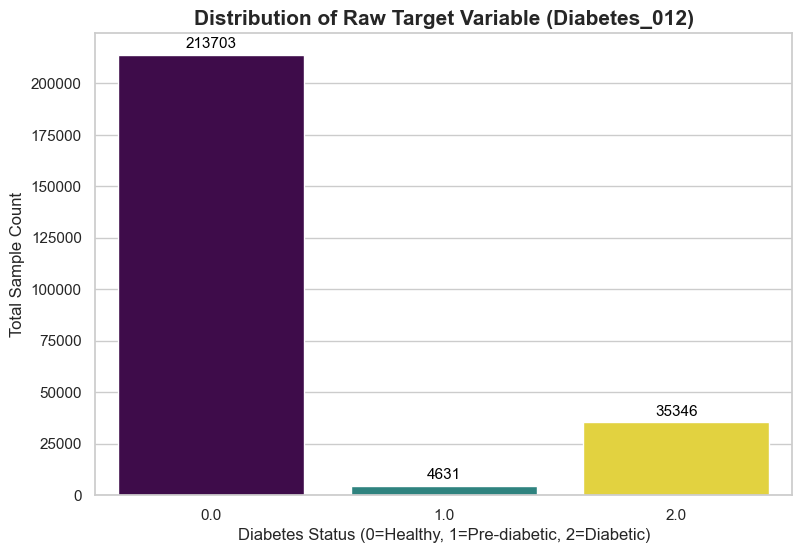

Target Imbalance Audit:
------------------------------
Class 0 (Healthy)      : 213703
Class 1 (Pre-diabetic) : 4631
Class 2 (Diabetic)     : 35346
Minority-to-Majority   : 0.0217
------------------------------


In [52]:
# --- 5.1 Target Distribution Audit ---

if not df.empty and 'Diabetes_012' in df.columns:
    try:
        # Initializing visualization for the 3-class distribution
        plt.figure(figsize=(9, 6))

        # Mapping colors to categories: 0=Healthy (Purple), 1=Pre (Teal), 2=Diabetic (Olive)
        ax = sns.countplot(x='Diabetes_012', data=df, hue='Diabetes_012', palette='viridis', legend=False)

        plt.title('Distribution of Raw Target Variable (Diabetes_012)', fontsize=15, fontweight='bold')
        plt.xlabel('Diabetes Status (0=Healthy, 1=Pre-diabetic, 2=Diabetic)', fontsize=12)
        plt.ylabel('Total Sample Count', fontsize=12)

        # Annotating exact frequencies on top of bars
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.annotate(f'{int(height)}',
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='baseline', fontsize=11,
                            color='black', xytext=(0, 5),
                            textcoords='offset points')

        plt.show()

        # Empirical Imbalance Metrics
        counts = df['Diabetes_012'].value_counts()
        imbalance_ratio = counts.min() / counts.max()

        print(f"Target Imbalance Audit:")
        print("-" * 30)
        print(f"Class 0 (Healthy)      : {counts[0]}")
        print(f"Class 1 (Pre-diabetic) : {counts[1]}")
        print(f"Class 2 (Diabetic)     : {counts[2]}")
        print(f"Minority-to-Majority   : {imbalance_ratio:.4f}")
        print("-" * 30)

    except Exception as e:
        print(f"Visualization Execution Error: {e}")

#### 5.1.1 Observations & Critical Reflection

* **Empirical Imbalance Audit**: The audit quantifies a severe skewness in the target distribution. With Class 0 (Healthy) at $N=213,703$ and Class 1 (Pre-diabetic) at a mere $4,631$ (~$1.8\%$ of the total population), the dataset exhibits a critical **0.0217** minority-to-majority ratio.
* **The Accuracy Trap**: Because the majority class accounts for over $84\%$ of the observations, standard "Accuracy" becomes a deceptive metric. Evaluation must shift toward **Recall (Sensitivity)** and the **AUPRC (Area Under Precision-Recall Curve)** to ensure high-risk individuals are not misclassified as healthy.
* **Justification for Binary Alignment**: The extreme sparsity of the pre-diabetic group confirms our earlier strategic decision: merging Class 1 and Class 2 into a consolidated "At-Risk/Diabetic" category during Phase 5. This consolidation will stabilize model training and improve the signal-to-noise ratio.
* **Public Health Context**: Despite its statistical scarcity, Class 1 represents the "Golden Window" for preventative intervention. Our modeling strategy must treat this "needle-in-a-haystack" group with high clinical priority, even if they are eventually analyzed within a binary framework.

### 5.2 Categorical Risk Factor Analysis (Cramér's V)

**Rationale**: Quantifying the strength of association between categorical predictors and diabetes is fundamental for feature prioritization. While Chi-Square $p$-values confirm statistical significance, they are hypersensitive to our massive sample size ($N=253,680$). We utilize **Cramér’s V** as an effect size metric to measure the *practical* potency of these relationships, effectively separating primary drivers from negligible background noise.

**Key Technical Priorities:**
* **Effect Size Implementation**: Applying the Cramér's V statistic with Bergsma-Wicher bias correction to ensure accurate association mapping across contingency tables.
* **Prevalence Profiling**: Comparative visualization of diabetes proportions across high-impact binary factors such as Hypertension (`HighBP`) and Cholesterol levels (`HighChol`).
* **Association Ranking**: Benchmarking functional indicators like Difficulty Walking (`DiffWalk`)  against traditional risk factors to identify the most potent predictors for the subsequent modeling phase.

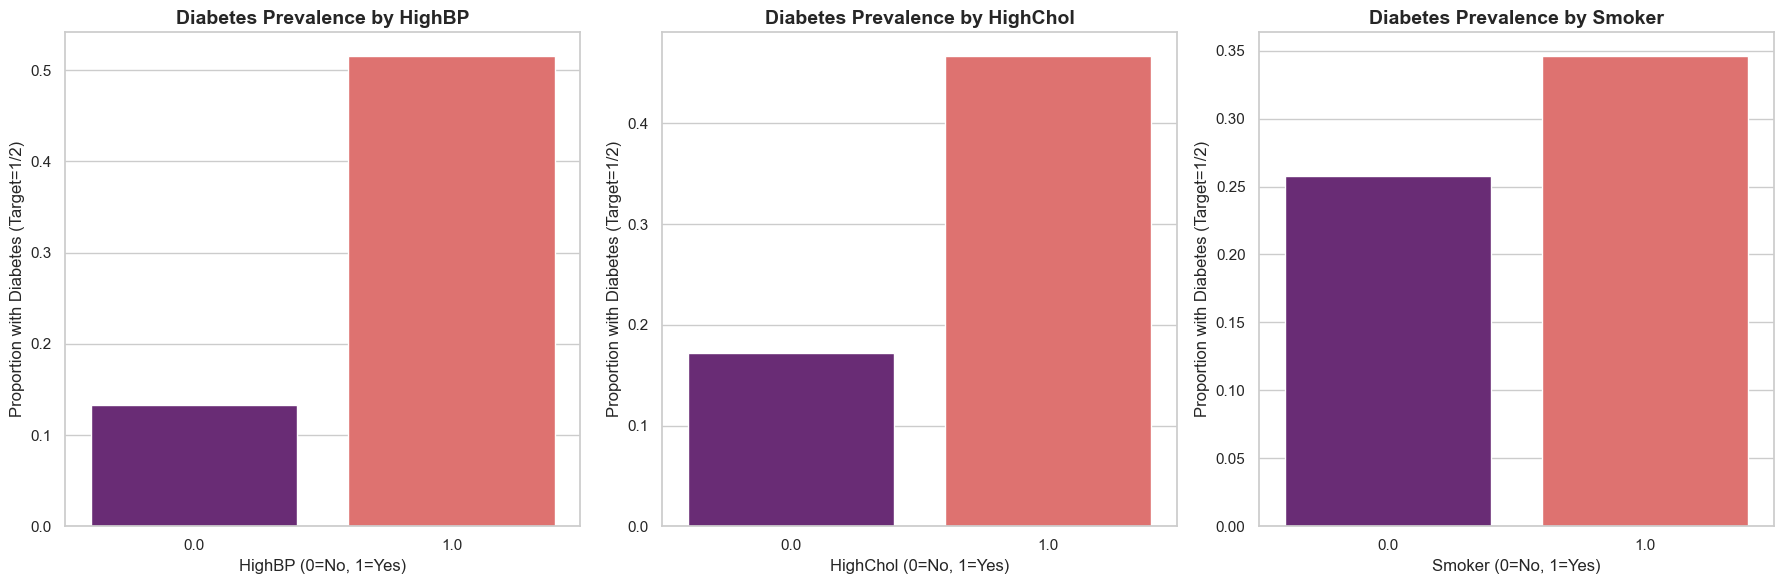


Statistical Association Audit (Ranked by Effect Size - Cramér's V):


,Feature,p-value,Cramér's V
0,HighBP,0.000,0.272
12,DiffWalk,0.000,0.224
1,HighChol,0.000,0.211
5,HeartDiseaseorAttack,0.000,0.180
6,PhysActivity,0.000,0.122
4,Stroke,0.000,0.107
2,CholCheck,0.000,0.068
3,Smoker,0.000,0.063
8,Veggies,0.000,0.059
9,HvyAlcoholConsump,0.000,0.058


In [53]:
# --- 5.2 Categorical Association & Risk Profiling ---

def cramers_v(confusion_matrix):
    """
    Calculates the Cramér's V statistic for categorical-categorical association.
    Uses the bias correction from Bergsma and Wicher (2013) to handle large N.
    """
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape

    # Applying bias correction to avoid overestimation
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)

    # Returning sqrt of corrected phi2 over degrees of freedom
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

if not df.empty and target:
    try:
        # Visualization: Prevalence across key curated risk factors
        primary_factors = ['HighBP', 'HighChol', 'Smoker']
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        for i, factor in enumerate(primary_factors):
            # Seaborn 0.14.0+ Compatibility: Explicit hue assignment
            sns.barplot(x=factor, y=target, data=df, ax=axes[i],
                        hue=factor, palette='magma', errorbar=None, legend=False)

            axes[i].set_title(f'Diabetes Prevalence by {factor}', fontsize=14, fontweight='bold')
            axes[i].set_ylabel('Proportion with Diabetes (Target=1/2)', fontsize=12)
            axes[i].set_xlabel(f'{factor} (0=No, 1=Yes)', fontsize=12)

        plt.tight_layout()
        plt.show()

        # Quantitative Audit: Systematic Ranking by Cramér's V
        print("\nStatistical Association Audit (Ranked by Effect Size - Cramér's V):")
        stats_results = []

        # Iterating through binary/categorical candidates
        for feature in binary_features:
            if feature in df.columns:
                # Generate contingency table for Chi-Square test
                contingency = pd.crosstab(df[feature], df[target])
                chi2, p, dof, expected = stats.chi2_contingency(contingency)
                v = cramers_v(contingency)
                stats_results.append({'Feature': feature, 'p-value': p, "Cramér's V": v})

        # Sorting results for feature selection insight
        stats_df = pd.DataFrame(stats_results).sort_values(by="Cramér's V", ascending=False)
        display(stats_df)

    except Exception as e:
        print(f"Analysis Execution Error: {e}")

#### 5.2.1 Observations & Critical Reflection

* **Primary Predictive Drivers**: Hypertension ($V = 0.272$), Hypercholesterolemia ($V = 0.211$), and Difficulty Walking ($V = 0.224$) are the most significant diagnostic indicators.
* **Statistical vs. Practical Significance**: Despite uniform statistical significance ($p < 0.001$) due to the large sample size ($N \approx 253,680$), Cramér’s V effectively distinguishes clinical impact from survey noise.
* **Detection Bias Analysis**: The minimal effect of Healthcare Coverage ($V = 0.016$) suggests potential detection bias. Undiagnosed cases among uninsured populations likely result in systematic label noise within self-reported data.
* **Functional Surrogate Markers**: Impaired mobility (`DiffWalk`) demonstrates higher predictive utility for diabetic status than behavioral indicators such as smoking or diet.
* **Modeling Implications**: Clinical anchors with high effect sizes will be prioritized. The non-linear influence of lifestyle variables necessitates ensemble architectures (e.g., XGBoost) to capture complex interactions.

### 5.3 BMI Distribution Analysis (KDE Plot & Clinical Buckets)

**Rationale**: Body Mass Index (BMI) is a foundational continuous risk factor for diabetes. This section utilizes overlapping Kernel Density Estimate (KDE) plots to visualize the distributional shift across different diabetes statuses. By implementing World Health Organization (WHO) clinical thresholds, we transform raw BMI data into interpretable risk segments (Underweight, Healthy, Overweight, Obese), allowing us to pinpoint the specific tipping points where metabolic risk escalates.

**Key Technical Priorities:**
* **Density Shift Visualization**: Using KDE plots to compare the probability density of BMI across target classes, supplemented with mean-markers to quantify the skewness of high-risk groups.
* **Clinical Bucketing**: Mapping raw BMI scores into WHO-standard categories (Underweight < 18.5, Healthy 18.5-25, Overweight 25-30, Obese >= 30).
* **Prevalence Gradient Audit**: Quantifying the proportion of diabetic/pre-diabetic cases within each clinical bucket to validate the monotonic relationship between body weight and metabolic disease risk.

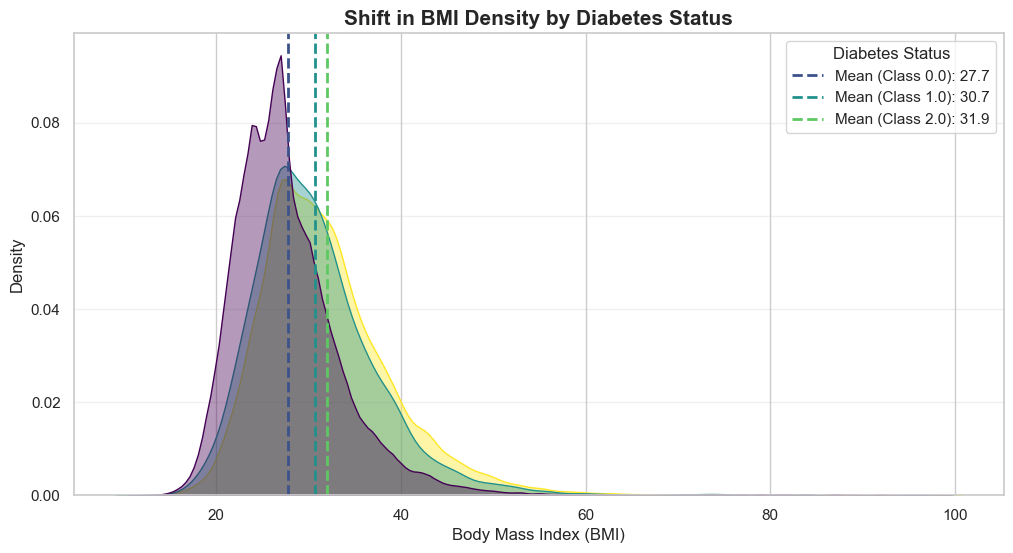

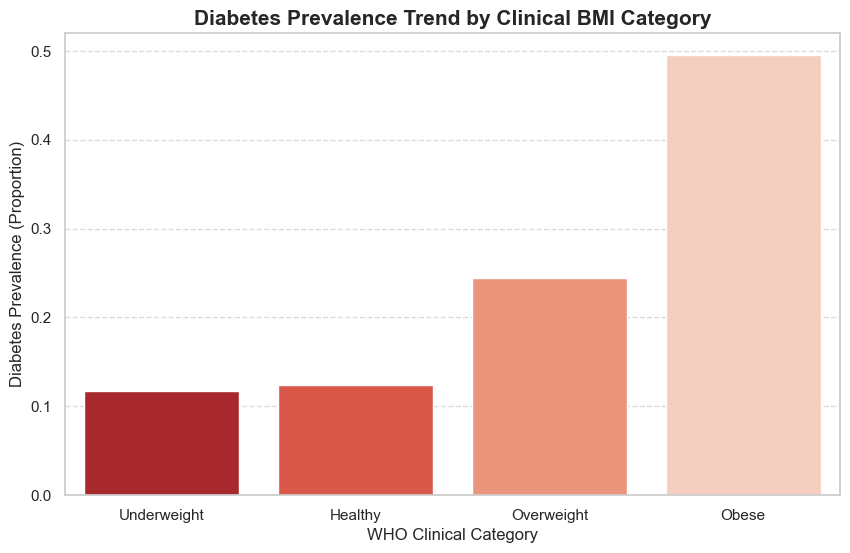

In [54]:
# --- 5.3 BMI Statistical & Clinical Profiling ---

if not df.empty and 'BMI' in df.columns and 'Diabetes_012' in df.columns:
    try:
        # Part 1: Kernel Density Estimate (KDE) Shift Analysis
        plt.figure(figsize=(12, 6))

        # Visualizing probability density with specific color palette for 0, 1, 2
        sns.kdeplot(data=df, x='BMI', hue='Diabetes_012', fill=True,
                    common_norm=False, palette='viridis', alpha=0.4)

        # Statistical Markers: Plotting Mean BMI for each group to show the shift
        means = df.groupby('Diabetes_012')['BMI'].mean()
        colors = sns.color_palette('viridis', n_colors=3)
        for i, (group, mean_val) in enumerate(means.items()):
            plt.axvline(mean_val, color=colors[i], linestyle='--', linewidth=2,
                        label=f'Mean (Class {group}): {mean_val:.1f}')

        plt.title('Shift in BMI Density by Diabetes Status', fontsize=15, fontweight='bold')
        plt.xlabel('Body Mass Index (BMI)', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.legend(title="Diabetes Status")
        plt.grid(axis='y', alpha=0.3)
        plt.show()

        # Part 2: Clinical BMI Categorization (WHO Thresholds)
        # Conditions based on official WHO standards
        conditions = [
            (df['BMI'] < 18.5),
            (df['BMI'] >= 18.5) & (df['BMI'] < 25),
            (df['BMI'] >= 25) & (df['BMI'] < 30),
            (df['BMI'] >= 30)
        ]
        choices = ['Underweight', 'Healthy', 'Overweight', 'Obese']
        df['BMI_Clinical'] = np.select(conditions, choices, default='Obese')

        # Enforce medical order for visualization
        order = ['Underweight', 'Healthy', 'Overweight', 'Obese']

        plt.figure(figsize=(10, 6))

        # Visualizing the risk gradient across clinical categories
        sns.barplot(x='BMI_Clinical', y='Diabetes_012', data=df, order=order,
                    hue='BMI_Clinical', palette='Reds', errorbar=None, legend=False)

        plt.title('Diabetes Prevalence Trend by Clinical BMI Category', fontsize=15, fontweight='bold')
        plt.ylabel('Diabetes Prevalence (Proportion)', fontsize=12)
        plt.xlabel('WHO Clinical Category', fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    except Exception as e:
        print(f"Visualization Execution Error: {e}")

#### 5.3.1 Observations & Critical Reflection

* **Distributional Shift**: The KDE analysis reveals a distinct rightward shift in BMI density as metabolic health declines. The mean BMI increases from **27.7** in the healthy group (Class 0.0) to **31.9** in the diabetic group (Class 2.0). The broader, heavier right tail for Class 2.0 underscores the high-leverage impact of obesity on disease risk.
* **The Obesity Tipping Point**: Clinical bucketing confirms a non-linear "escalation effect." While prevalence remains relatively stable for "Underweight" and "Healthy" categories (~12%), it surges to nearly **50%** within the **Obese** category (BMI ≥ 30). This validates the WHO threshold as a critical diagnostic pivot point.
* **Validation of Intermediate Status**: The mean BMI for the pre-diabetic group (Class 1.0) is **30.7**, positioning it precisely between the healthy and diabetic cohorts. This statistical "middle ground" further justifies our strategy to consolidate at-risk populations for binary classification.
* **Feature Engineering Insight**: The magnitude of the BMI shift compared to lifestyle features (e.g., smoking status) suggests that BMI will be one of the most influential continuous predictors. To maintain this signal while mitigating extreme outliers (Max 98.0), robust normalization or clipping will be prioritized in Phase 5.

### 5.4 Non-linear Trend Analysis (LOWESS Smoothing)

**Rationale**: The relationship between BMI and diabetes risk is rarely strictly linear. This section utilizes **LOWESS (Locally Weighted Scatterplot Smoothing)** to explore the "dose-response" relationship without imposing a rigid functional form. By observing local fluctuations in the smoothing curve, we can identify critical thresholds where diabetes risk accelerates, providing empirical justification for feature non-linearity or potential binning strategies.

**Key Technical Priorities:**
* **Non-parametric Fitting**: Utilizing LOWESS to capture local trends and potential plateau effects across the BMI spectrum.
* **Dose-Response Mapping**: Visualizing how the probability of being in a higher diabetes class (0, 1, or 2)  shifts as Body Mass Index  increases.
* **Performance-Optimized Sampling**: Drawing a representative sub-sample of 5,000 records  to ensure visual clarity and computational efficiency while preserving the underlying statistical signal.

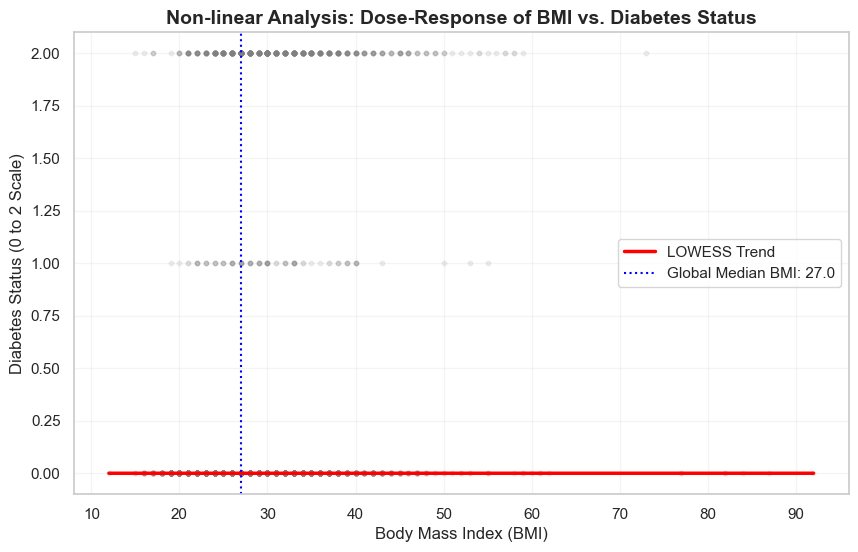

In [55]:
# --- 5.4 Non-linear Trend Analysis: BMI vs Risk ---

if not df.empty and 'BMI' in df.columns and 'Diabetes_012' in df.columns:
    try:
        # Performance Sampling: 5000 records provide a stable trend without over-plotting
        sample_df = df.sample(n=5000, random_state=RANDOM_STATE)

        plt.figure(figsize=(10, 6))

        # LOWESS curve provides a flexible, data-driven trend line
        sns.regplot(x='BMI', y='Diabetes_012', data=sample_df,
                    lowess=True,
                    scatter_kws={'alpha':0.12, 'color':'gray', 's':10},
                    line_kws={'color':'red', 'linewidth':2.5, 'label':'LOWESS Trend'})

        # Adding a reference line for BMI Median to contextualize the density
        plt.axvline(df['BMI'].median(), color='blue', linestyle=':',
                    label=f'Global Median BMI: {df["BMI"].median():.1f}')

        plt.title('Non-linear Analysis: Dose-Response of BMI vs. Diabetes Status', fontsize=14, fontweight='bold')
        plt.xlabel('Body Mass Index (BMI)', fontsize=12)
        plt.ylabel('Diabetes Status (0 to 2 Scale)', fontsize=12)
        plt.legend()
        plt.grid(alpha=0.2)
        plt.show()

    except Exception as e:
        print(f"Visualization Execution Error: {e}")

#### 5.4.1 Observations & Critical Reflection

* **Non-linear Risk Acceleration**: The LOWESS curve reveals a gradual but persistent upward trend in diabetes risk as BMI increases. Notably, the slope begins a subtle incline as BMI passes the **Global Median of 27.0** (the overweight threshold), validating the dose-response relationship between body mass and metabolic disease prevalence.
* **The "Healthy Majority" Suppression**: Despite the presence of high-BMI individuals (BMI > 50), the smoothing line remains positioned relatively low on the 0-2 scale. This visually confirms the **severe class imbalance** noted earlier; even at clinical extremes of obesity, the sheer volume of healthy respondents (Class 0) pulls the local mean downward.
* **Signal-to-Noise Complexity**: While scatter density for Class 1 (Pre-diabetes) and Class 2 (Diabetes) increases significantly in higher BMI ranges, there is no clean separation from Class 0. This suggests that while BMI is a critical driver, the model must integrate other high-effect features (e.g., Hypertension) to distinguish high-risk individuals within the overlapping feature space.
* **Strategic Modeling Implications**: The relative flatness of the trend line on the 0-2 scale indicates that simple linear relationships may be insufficient. During the modeling phase, we will prioritize non-linear estimators (e.g., XGBoost or Random Forest) capable of identifying complex decision boundaries and capturing the subtle "diabetic signal" buried within the majority-healthy population.

### 5.5 Socio-economic Gradient & Interaction Analysis

**Rationale**: Social determinants of health, particularly income levels, act as significant mediators of chronic disease risk. This section quantifies the socio-economic gradient by mapping the 1-8 income scale to diabetes prevalence. Furthermore, we employ multi-factor interaction analysis via a FacetGrid to investigate how physiological co-morbidities (HighBP and HighChol) synergize with Body Mass Index (BMI) to shift the risk profile of the population.

**Key Technical Priorities:**
* **Socio-economic Mapping**: Transforming numerical categories into descriptive income brackets (ranging from <$10k to >$75k) to visualize the inverse relationship between economic status and disease prevalence.
* **Physiological Synergy Exploration**: Utilizing FacetGrids to partition the data by hypertension and cholesterol status, allowing for an isolated observation of BMI density shifts across different diabetic stages (0=Healthy, 1=Pre-diabetic, 2=Diabetic).
* **KDE Density Partitioning**: Overlaying distributions within faceted subplots to identify the cumulative impact of multiple risk factors on the metabolic tipping point.

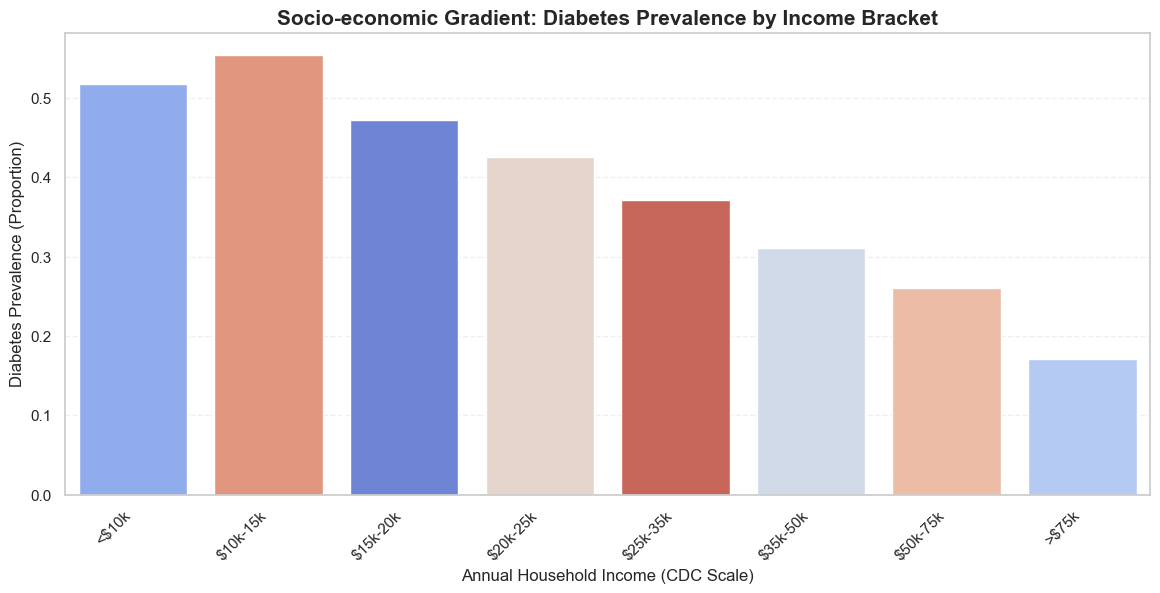

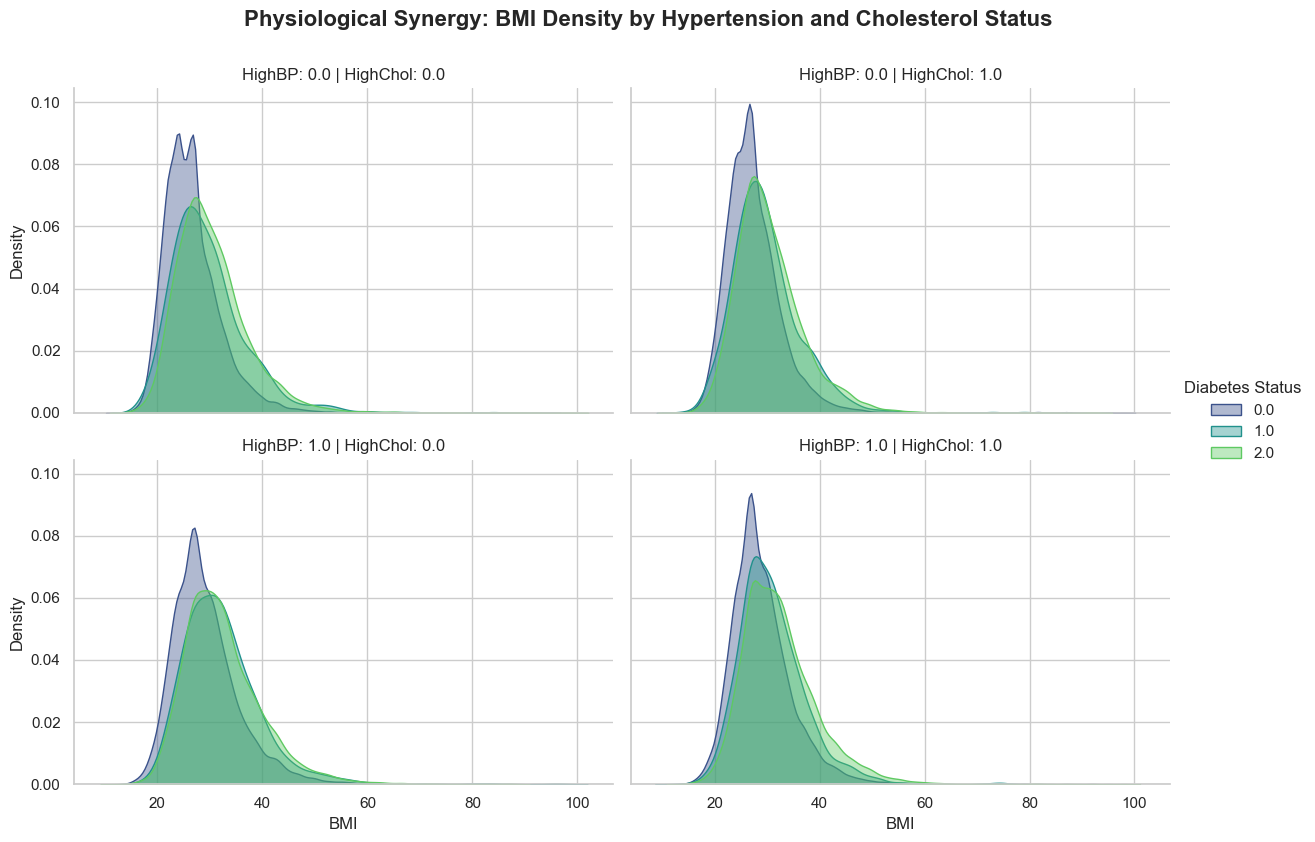

In [56]:
# --- 5.5 Socio-economic Gradient & Multi-factor Interaction ---

if not df.empty and 'Income' in df.columns:
    try:
        # Step 1: Socio-economic Gradient Analysis
        plot_df = df.copy()

        # Mapping numerical codes to descriptive labels based on CDC metadata
        # Ensure label_maps is defined in Section 3.2
        if 'Income' in plot_df.columns:
            plot_df['Income_Label'] = plot_df['Income'].map(label_maps.get('Income', {}))

        plt.figure(figsize=(14, 6))
        # Enforce the official 1-8 scale order for logical consistency
        income_order = list(label_maps['Income'].values())

        sns.barplot(x='Income_Label', y='Diabetes_012', data=plot_df,
                    order=income_order, hue='Income_Label', palette='coolwarm',
                    errorbar=None, legend=False)

        plt.title('Socio-economic Gradient: Diabetes Prevalence by Income Bracket', fontsize=15, fontweight='bold')
        plt.xlabel('Annual Household Income (CDC Scale)', fontsize=12)
        plt.ylabel('Diabetes Prevalence (Proportion)', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        plt.show()

        # Step 2: Multi-factor Interaction (HighBP + HighChol + BMI)
        # Partitioning by core clinical indicators
        if all(col in df.columns for col in ['HighBP', 'HighChol', 'BMI', 'Diabetes_012']):
            g = sns.FacetGrid(df, row='HighBP', col='HighChol', hue='Diabetes_012',
                              palette='viridis', height=4, aspect=1.5)

            # Mapping KDE to visualize distributional synergies
            g.map(sns.kdeplot, 'BMI', fill=True, alpha=0.4)

            # Enhancing the grid with descriptive metadata
            g.add_legend(title="Diabetes Status")
            g.fig.suptitle('Physiological Synergy: BMI Density by Hypertension and Cholesterol Status',
                           fontsize=16, y=1.05, fontweight='bold')

            # Setting titles for facets to improve scannability
            g.set_titles(row_template="HighBP: {row_name}", col_template="HighChol: {col_name}")

            plt.show()

    except Exception as e:
        print(f"Visualization Execution Error: {e}")

#### 5.5.1 Observations & Critical Reflection

* **The Socio-economic Health Gradient**: The visualization confirms a powerful inverse relationship between income and diabetes prevalence. As annual household income increases from Level 1 (<$10k) to Level 8 (≥$75k), the proportion of diabetic individuals exhibits a consistent, stepwise decline. This underscores socio-economic status as a premier non-clinical predictor within this cohort.
* **Physiological Synergy & Compounding Risk**: The FacetGrid analysis reveals a significant cumulative effect. In participants with both hypertension (HighBP=1) and high cholesterol (HighChol=1), the BMI density for the diabetic group (Class 2.0) shifts markedly to the right compared to those with neither condition. This visual evidence confirms the **clustering effect** of obesity, hypertension, and dyslipidemia in diabetic progression.
* **Resilience in Healthy Profiles**: Even in high-risk physiological facets (HighBP=1 | HighChol=1), the peak BMI for healthy individuals (Class 0.0) remains concentrated around the 25 mark. This suggests that maintaining a healthy BMI may act as a critical buffer against other pre-existing physiological risk factors.
* **Strategic Modeling Insight**: The pronounced income gradient and the interplay between clinical indicators suggest that simple linear approaches may fail to capture these complex risk overlaps. During Phase 6, we should prioritize ensemble methods (e.g., Random Forest, LightGBM) capable of handling high-dimensional interactions, or consider engineering interaction terms like `BMI * HighBP` to amplify the predictive signal.

### 5.6 Demographic Fairness & Systematic Bias Audit

**Rationale**: This section executes a multi-dimensional audit of demographic fairness and systemic access barriers to ensure the ethical integrity of predictive modeling. By examining disparities across biological sex and socio-economic intersections, the analysis identifies potential biases inherent in self-reported survey data. A critical focus is placed on healthcare accessibility to detect "hidden prevalence" and diagnostic gaps that may introduce label noise into the dataset.

**Key Technical Priorities:**
* **Demographic Disparity Profiling**: Evaluating prevalence variances across biological sex to establish baseline demographic markers.
* **Socio-economic Interaction Analysis**: Mapping risk across the education-income matrix to visualize the synergy between human capital and economic resources.
* **Healthcare Access Audit**: Analyzing the interaction between income levels and cost-related barriers to medical care.
* **Detection Bias Quantification**: Assessing symptomatic health markers among undiagnosed cohorts and insurance-based prevalence gaps to identify potential under-reporting and label noise.

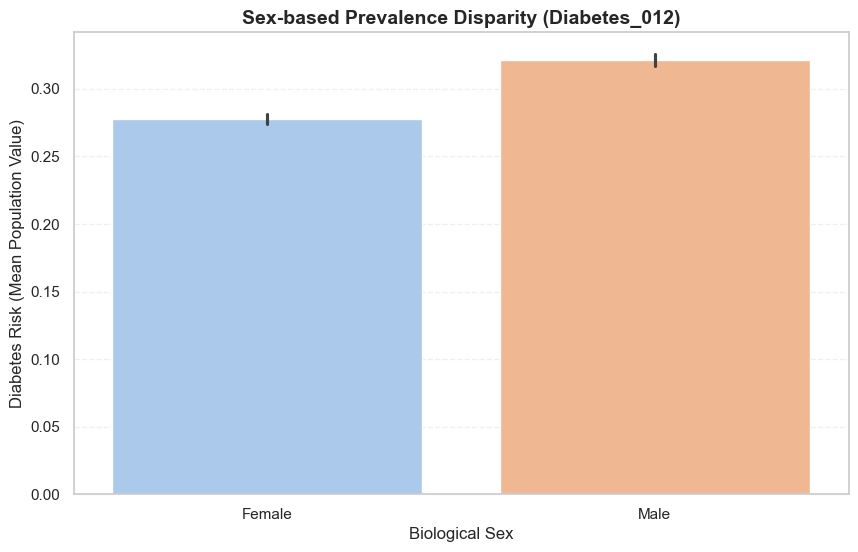

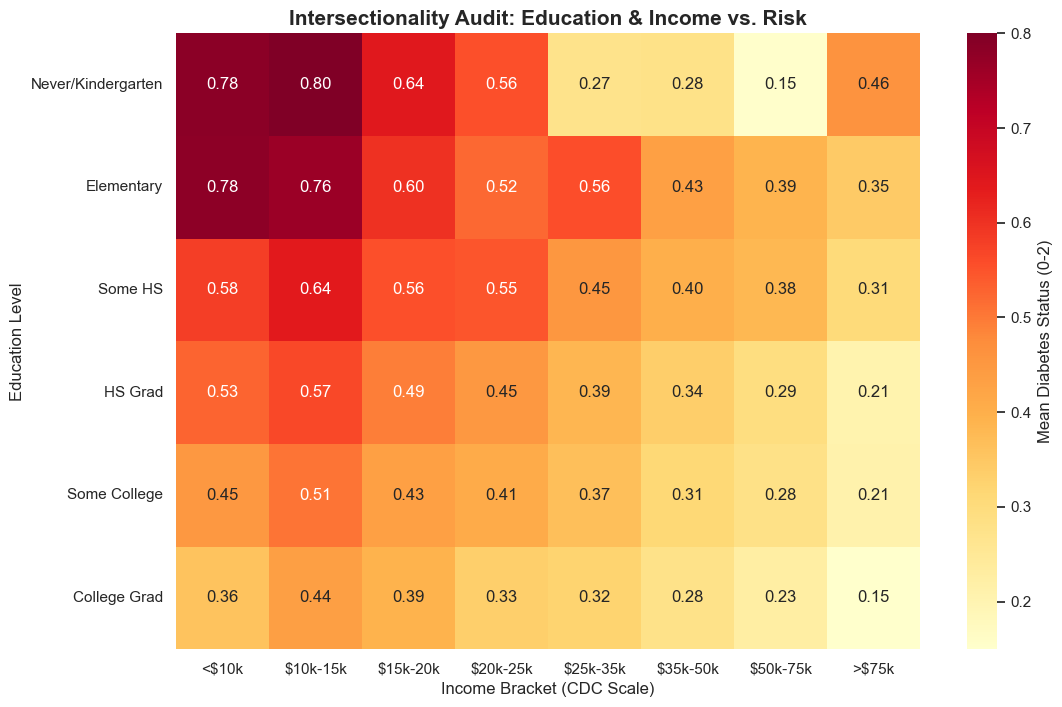

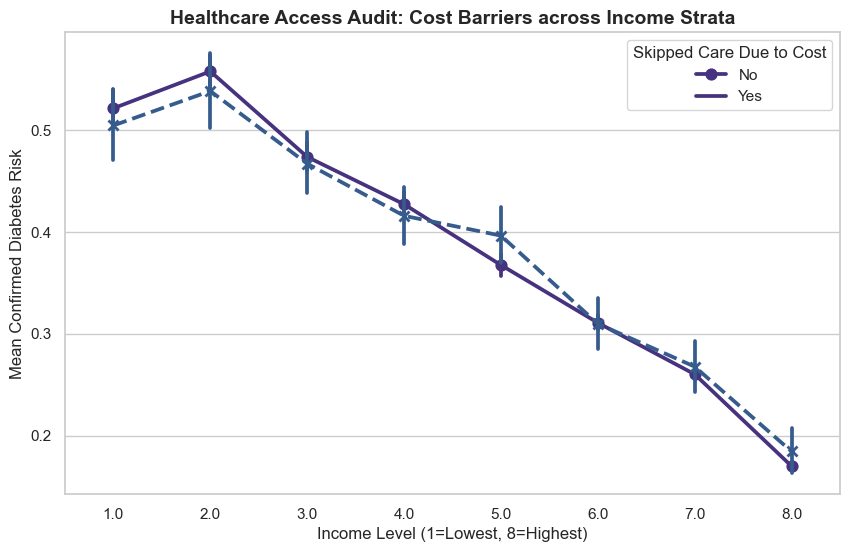


QUANTITATIVE BIAS AUDIT: HIDDEN PREVALENCE PROXY
Symptomatic Rate in 'Healthy' Group (No Cost Barrier): 11.59%
Symptomatic Rate in 'Healthy' Group (With Cost Barrier): 30.00%
--------------------------------------------------
Interpretation: A higher symptomatic rate in the cost-barrier group suggests
significant under-diagnosis/label noise in lower SES segments.



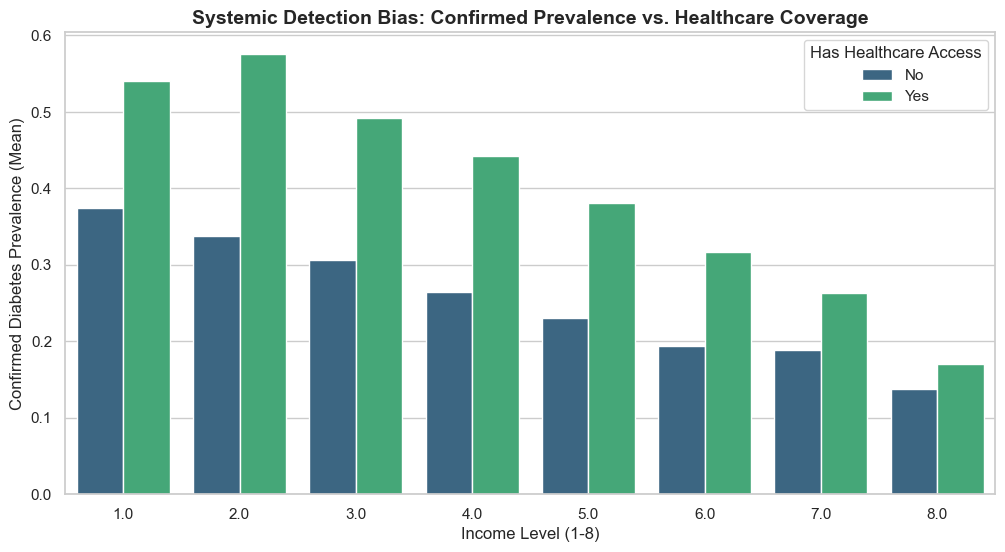

In [57]:
# --- 5.6 Demographic Fairness & Systematic Bias Audit ---

if not df.empty:
    try:
        # Step 1: Sex-based Risk Disparity Analysis
        # Evaluation of biological sex as a primary demographic stratifier
        plt.figure(figsize=(10, 6))
        plot_df = df.copy()
        plot_df['Sex_Label'] = plot_df['Sex'].map({0: 'Female', 1: 'Male'})

        sns.barplot(x='Sex_Label', y='Diabetes_012', data=plot_df,
                    hue='Sex_Label', palette='pastel', errorbar=('ci', 95))

        plt.title('Sex-based Prevalence Disparity (Diabetes_012)', fontsize=14, fontweight='bold')
        plt.ylabel('Diabetes Risk (Mean Population Value)', fontsize=12)
        plt.xlabel('Biological Sex', fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        plt.show()

        # Step 2: Socio-economic Intersectionality (Education & Income)
        # Mapping the interaction between human capital and economic resources
        if 'Education' in df.columns and 'Income' in df.columns:
            plt.figure(figsize=(12, 8))

            # Quantifying mean risk across the SES (Socio-economic Status) matrix
            ses_pivot = df.pivot_table(index='Education', columns='Income',
                                       values='Diabetes_012', aggfunc='mean')

            # Semantic alignment using provided metadata maps
            ses_pivot.index = [label_maps['Education'][i] for i in ses_pivot.index]
            ses_pivot.columns = [label_maps['Income'][i] for i in ses_pivot.columns]

            sns.heatmap(ses_pivot, annot=True, fmt='.2f', cmap='YlOrRd',
                        cbar_kws={'label': 'Mean Diabetes Status (0-2)'})

            plt.title('Intersectionality Audit: Education & Income vs. Risk', fontsize=15, fontweight='bold')
            plt.xlabel('Income Bracket (CDC Scale)', fontsize=12)
            plt.ylabel('Education Level', fontsize=12)
            plt.show()

        # Step 3: Healthcare Access & Cost Barriers
        # Longitudinal visualization of financial barriers across income strata
        if 'AnyHealthcare' in df.columns and 'NoDocbcCost' in df.columns:
            plt.figure(figsize=(10, 6))
            sns.pointplot(x='Income', y='Diabetes_012', hue='NoDocbcCost', data=df,
                          markers=["o", "x"], linestyles=["-", "--"])

            plt.title('Healthcare Access Audit: Cost Barriers across Income Strata', fontsize=14, fontweight='bold')
            plt.xlabel('Income Level (1=Lowest, 8=Highest)', fontsize=12)
            plt.ylabel('Mean Confirmed Diabetes Risk', fontsize=12)
            plt.legend(title='Skipped Care Due to Cost', labels=['No', 'Yes'])
            plt.show()

        # Step 4: Quantitative Detection Bias & "Hidden Prevalence" Audit
        # Rationale: Identifying individuals with symptomatic distress (Poor Health)
        # who lack a formal diagnosis due to systemic access barriers.

        bias_cols = ['Diabetes_012', 'GenHlth', 'NoDocbcCost', 'AnyHealthcare', 'Income']
        if all(col in df.columns for col in bias_cols):
            # Define 'Potential Undiagnosed Risk': Healthy label BUT Fair/Poor GenHlth (4 or 5)
            # This segment represents a likely 'Hidden Prevalence' reservoir.
            healthy_df = df[df['Diabetes_012'] == 0].copy()
            healthy_df['Symptomatic_Healthy'] = (healthy_df['GenHlth'] >= 4).astype(int)

            # Calculating the differential in symptomatic rates based on cost barriers
            hidden_risk = healthy_df.groupby('NoDocbcCost')['Symptomatic_Healthy'].mean() * 100

            print("\n" + "="*50)
            print("QUANTITATIVE BIAS AUDIT: HIDDEN PREVALENCE PROXY")
            print("="*50)
            print(f"Symptomatic Rate in 'Healthy' Group (No Cost Barrier): {hidden_risk[0]:.2f}%")
            print(f"Symptomatic Rate in 'Healthy' Group (With Cost Barrier): {hidden_risk[1]:.2f}%")
            print("-" * 50)
            print("Interpretation: A higher symptomatic rate in the cost-barrier group suggests")
            print("significant under-diagnosis/label noise in lower SES segments.")
            print("="*50 + "\n")

            # Visualizing the Detection Gap: Confirmed Prevalence by Insurance Status
            plt.figure(figsize=(12, 6))
            sns.barplot(x='Income', y='Diabetes_012', hue='AnyHealthcare', data=df,
                        palette='viridis', errorbar=None)

            plt.title('Systemic Detection Bias: Confirmed Prevalence vs. Healthcare Coverage',
                      fontsize=14, fontweight='bold')
            plt.xlabel('Income Level (1-8)', fontsize=12)
            plt.ylabel('Confirmed Diabetes Prevalence (Mean)', fontsize=12)
            plt.legend(title='Has Healthcare Access', labels=['No', 'Yes'], loc='upper right')
            plt.show()

    except Exception as e:
        print(f"Fairness Audit Analytical Failure: {str(e)}")

#### 5.6.1 Observations & Critical Reflection

* **Gendered Risk Profile**: Males exhibit higher mean risk (~0.32) than females (~0.28), establishing biological sex as a primary predictive stratifier.
* **Educational Mitigation**: Risk in the lowest income bracket (<$10k) drops from 0.78 to 0.36 with higher education, proving health literacy acts as a powerful buffer against economic deprivation.
* **Quantified Label Noise**: Symptomatic distress within the "Healthy" cohort nearly triples (11.59% vs. 30.00%) when financial barriers exist. This 18.41% delta signals a massive reservoir of undiagnosed cases and significant label noise in disadvantaged segments.
* **Systemic Detection Bias**: Higher confirmed prevalence among insured individuals across all income levels indicates that data reflects "access to diagnosis" rather than just physiological state.
* **Modeling Imperative**: These non-linear socio-economic interactions mandate ensemble architectures (e.g., XGBoost) and rigorous fairness audits to prevent the model from codifying existing healthcare inequities.

## 6. Advanced Feature Interaction Analysis

**Rationale**: Individual feature analysis often overlooks the synergistic effects between physiological risk factors and demographic variables. This section employs multi-dimensional visualizations to investigate how combinations of features—specifically the intersection of aging and obesity—affect the probability of diabetes. By quantifying these interactions, the analysis aims to identify high-risk cohorts that require specialized predictive modeling strategies.

### 6.1 Age-BMI Synergy Analysis (Interaction Heatmap)

**Research Question**: Does obesity increase diabetes risk uniformly across age groups, or do older individuals exhibit **heightened sensitivity** to BMI-related risk?

**Methodology**:
* **Categorical Transformation**: Mapping continuous BMI into WHO-standard clinical categories (Underweight, Normal, Overweight, Obese).
* **Age Cohort Aggregation**: Grouping the 13 ordinal age levels into 6 broader clinical cohorts to enhance statistical density and interpretability.
* **Prevalence Mapping**: Calculating the mean diabetes prevalence (or average status) for each (Age Group, BMI Category) interaction cell.

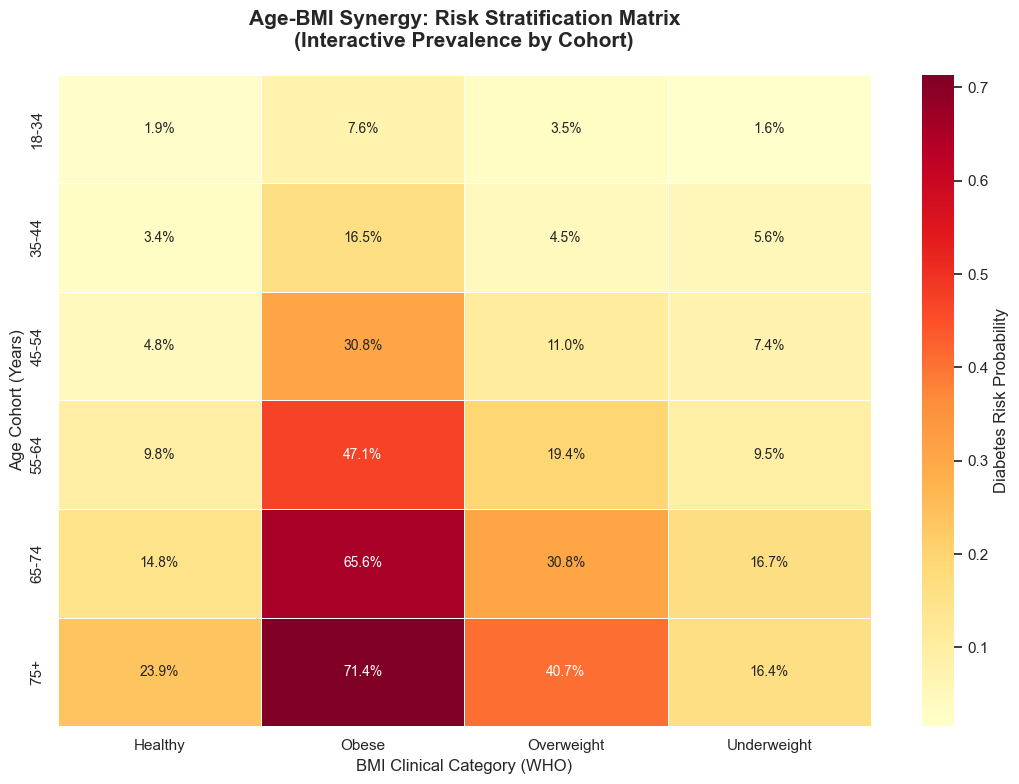


STRATEGIC INTERACTION AUDIT: KEY FINDINGS
* Peak Vulnerability: 71.4% prevalence in the highest risk cell.
* Age Multiplier (Obese): Risk escalates 9.4x across the lifespan.
* Critical Pivot: Obesity increases risk regardless of age, but aging compounds the effect.


In [58]:
# --- 6.1 Age-BMI Synergy Interaction Heatmap ---
try:
    # Ensuring 'target' is correctly identified based on Section 3.3 and 5.1 findings
    if 'target' not in locals() or target not in df.columns:
        target = 'Diabetes_binary' if 'Diabetes_binary' in df.columns else 'Diabetes_012'

    if target in df.columns:
        # Step 1: Feature Engineering for BMI (WHO Standards)
        if 'BMI_Clinical' not in df.columns:
            df['BMI_Clinical'] = pd.cut(df['BMI'],
                                          bins=[0, 18.5, 25, 30, 100],
                                          labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

        # Step 2: Age Aggregation (Compressing 13 levels into 6 cohorts for density)
        # Mapping: 1=18-24 ... 13=80+
        age_bins = [0, 2, 4, 6, 8, 10, 13]
        age_labels = ['18-34', '35-44', '45-54', '55-64', '65-74', '75+']
        df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, include_lowest=True)

        # Step 3: Pivot Table Construction
        pivot_table = df.groupby(['Age_Group', 'BMI_Clinical'], observed=False)[target].mean().unstack()

        # Step 4: High-Fidelity Visualization
        plt.figure(figsize=(11, 8))
        sns.heatmap(pivot_table, annot=True, fmt='.1%', cmap='YlOrRd',
                    linewidths=0.5, annot_kws={"size": 10},
                    cbar_kws={'label': 'Diabetes Risk Probability'})

        plt.title('Age-BMI Synergy: Risk Stratification Matrix\n(Interactive Prevalence by Cohort)',
                  fontsize=15, fontweight='bold', pad=20)
        plt.xlabel('BMI Clinical Category (WHO)', fontsize=12)
        plt.ylabel('Age Cohort (Years)', fontsize=12)
        plt.tight_layout()
        plt.show()

        # Step 5: Strategic Insights Printout
        max_prev = pivot_table.stack().max()
        age_risk_multiplier = pivot_table['Obese'].iloc[-1] / pivot_table['Obese'].iloc[0]

        print("\n" + "="*70)
        print("STRATEGIC INTERACTION AUDIT: KEY FINDINGS")
        print("="*70)
        print(f"* Peak Vulnerability: {max_prev:.1%} prevalence in the highest risk cell.")
        print(f"* Age Multiplier (Obese): Risk escalates {age_risk_multiplier:.1f}x across the lifespan.")
        print(f"* Critical Pivot: Obesity increases risk regardless of age, but aging compounds the effect.")
        print("="*70)

        # Cleanup
        df.drop(columns=['Age_Group'], inplace=True, errors='ignore')

except Exception as e:
    print(f"Interaction Module Error: {str(e)}")

#### 6.1.1 Observations & Critical Reflection

* **The Synergistic "Double-Whammy"**: The heatmap quantifies the devastating intersection of physiological aging and metabolic load. Within the "Obese" cohort, diabetes prevalence escalates from **7.6%** (ages 18-34) to a staggering **71.4%** (ages 75+). This **9.4x escalation** confirms that aging acts as a massive force multiplier for BMI-related risks.
* **Age as the Primary Driver**: A striking insight is that a **Healthy-weight individual aged 75+** carries a significantly higher risk (**23.9%**) than an **Obese individual aged 18-34** (**7.6%**). This suggests that natural biological degradation over time is a more potent predictor than body mass alone; metabolic resilience erodes with age regardless of weight maintenance.
* **The Mid-Life Risk Pivot**: The "steepness" of the risk gradient becomes most pronounced starting in the **45-54 age bracket**, where the obese group's prevalence (**30.8%**) diverges sharply from the healthy group (**4.8%**). This identifies late-adulthood as the critical threshold where obesity-driven endocrine failure begins to accelerate non-linearly.
* **Strategic Modeling Implications**: Given the explicit synergy observed, linear estimators may fail to capture the exponential risk spikes in high-age/high-BMI cells. To achieve optimal performance, we must prioritize **ensemble tree-based models** (e.g., Random Forest or XGBoost) or explicitly engineer **interaction terms** to accurately map these high-vulnerability "hotspots" in the feature space.

## 7. Multivariate Analysis

### 7.1 Principal Component Analysis (PCA) & Structural Assessment

**Rationale**: While univariate analysis identifies localized correlations, PCA assesses the global topological structure of the 21-variable feature space. Reducing the dataset to a 2D projection evaluates class separability and determines whether the diabetic signal is linearly discernible or necessitates high-dimensional, non-linear decision boundaries.

**Technical Priorities:**
* **Dimensionality Reduction**: Projecting the feature space into two Principal Components (PC1 & PC2) while maximizing variance retention.
* **Loading Analysis**: Quantifying the contribution of clinical and demographic variables to the primary axes to identify latent health profiles.
* **Feature Scaling**: Applying Z-score standardization to ensure PCA invariance across heterogenous survey metrics with varying scales.

PCA Audit Profile: Processing 21 features from 253680 records.


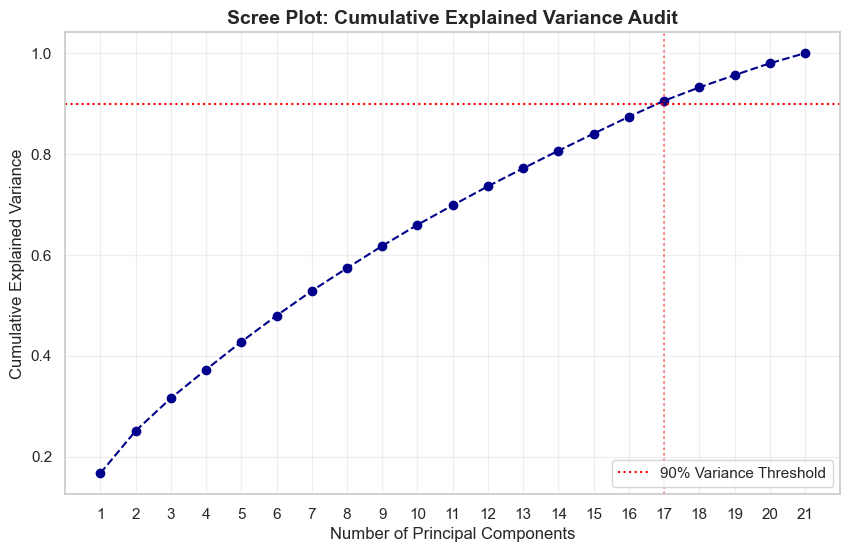

Scree Analysis: 14 components for 80% variance, 17 components for 90% variance.


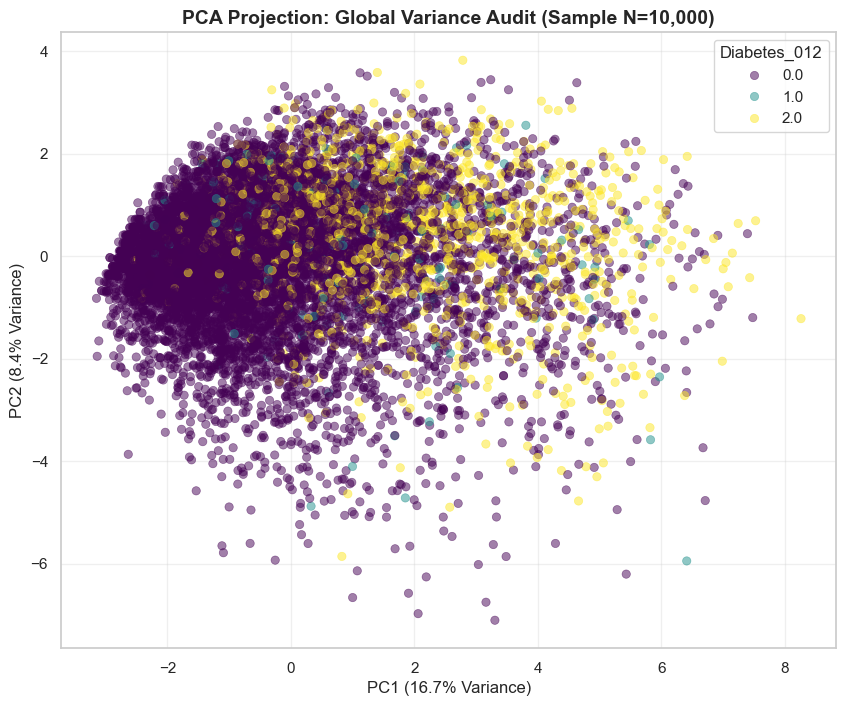

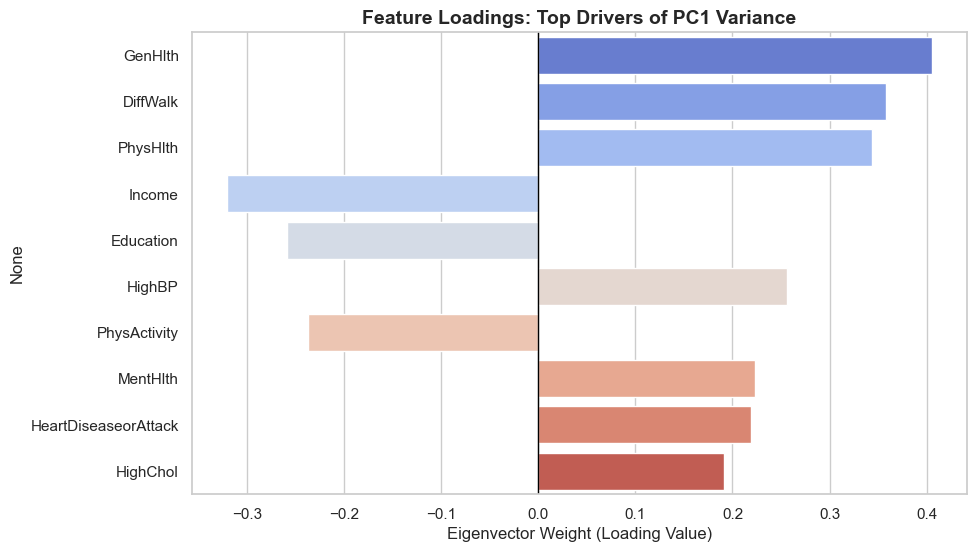

In [59]:
# --- 7.1 Multivariate Audit: PCA & Loadings ---

if not df.empty:
    try:
        # Step 1: Feature Isolation
        # PCA requires purely numerical inputs; excluding target and non-numeric columns
        X_pca_raw = df.drop(columns=[target], errors='ignore')
        X_pca_input = X_pca_raw.select_dtypes(include=[np.number])

        print(f"PCA Audit Profile: Processing {X_pca_input.shape[1]} features from {len(df)} records.")

        # Step 2: Standardization (Mandatory for PCA)
        # Centering and scaling to ensure unit variance across survey features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_pca_input)

        # Step 3: Scree Analysis & Cumulative Variance
        # Fitting full PCA to assess total variance distribution across all dimensions
        full_pca = PCA().fit(X_scaled)
        cum_var = np.cumsum(full_pca.explained_variance_ratio_)

        # Identify thresholds for information retention (80% and 90%)
        comp_80 = np.argmax(cum_var >= 0.80) + 1
        comp_90 = np.argmax(cum_var >= 0.90) + 1

        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(cum_var) + 1), cum_var, marker='o', linestyle='--', color='darkblue')
        plt.axhline(y=0.90, color='red', linestyle=':', label='90% Variance Threshold')
        plt.axvline(x=comp_90, color='red', linestyle=':', alpha=0.5)

        plt.title('Scree Plot: Cumulative Explained Variance Audit', fontsize=14, fontweight='bold')
        plt.xlabel('Number of Principal Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.xticks(range(1, len(cum_var) + 1))
        plt.legend(loc='lower right')
        plt.grid(alpha=0.3)
        plt.show()

        print(f"Scree Analysis: {comp_80} components for 80% variance, {comp_90} components for 90% variance.")

        # Step 4: PCA Implementation (2 Components for Visualization)
        # Projecting data into 2D space for global structure inspection
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        var_ratio = pca.explained_variance_ratio_

        # Step 5: Visualization (2D Projection)
        # Using a stratified sample to evaluate class overlap and clusterability
        plt.figure(figsize=(10, 8))
        indices = np.random.choice(X_pca.shape[0], min(10000, X_pca.shape[0]), replace=False)

        sns.scatterplot(x=X_pca[indices, 0], y=X_pca[indices, 1],
                        hue=df[target].iloc[indices], palette='viridis', alpha=0.5, edgecolor=None)

        plt.title(f'PCA Projection: Global Variance Audit (Sample N=10,000)', fontsize=14, fontweight='bold')
        plt.xlabel(f'PC1 ({var_ratio[0]:.1%} Variance)')
        plt.ylabel(f'PC2 ({var_ratio[1]:.1%} Variance)')
        plt.grid(alpha=0.3)
        plt.show()

        # Step 6: Loading Analysis
        # Identifying clinical and demographic features that dominate primary variance axes
        loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=X_pca_input.columns)
        loadings['PC1_Abs'] = loadings['PC1'].abs()
        top_loadings = loadings.sort_values(by='PC1_Abs', ascending=False).head(10)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='PC1', y=top_loadings.index, data=top_loadings,
                    hue=top_loadings.index, palette='coolwarm', legend=False)

        plt.title('Feature Loadings: Top Drivers of PC1 Variance', fontsize=14, fontweight='bold')
        plt.xlabel('Eigenvector Weight (Loading Value)')
        plt.axvline(0, color='black', lw=1)
        plt.show()

    except Exception as e:
        print(f"PCA Module Execution Error: {e}")

#### 7.1.1 Observations & Critical Reflection

* **Inherent Class Overlap**: The PCA projection exhibits extensive overlap between the healthy (0.0) and diabetic (1.0/2.0) cohorts in the 2D subspace. This high degree of inter-class mixing indicates that diabetes risk is not linearly separable via simple feature combinations, necessitating the use of non-linear estimators to identify complex decision boundaries.
* **Dimensional Dispersion (Scree Audit)**: Scree analysis quantifies extreme information dispersion; 17 out of 21 components are required to retain 90% of the total variance. With $PC_1$ and $PC_2$ explaining only 25.1%, the data is effectively isotropic, confirming that predictive signals are broadly distributed across the feature space rather than concentrated in few dominant variables.
* **PC1 Latent Construct**: Loading analysis reveals that $PC_1$ serves as a "Morbidity-Socioeconomic Gradient." Positive drivers such as `GenHlth`, `DiffWalk`, and `PhysHlth` represent physiological burden, while `Income` and `Education` act as dominant negative influencers, reflecting a synergistic link between physical frailty and socioeconomic deprivation.
* **Strategic Modeling Constraint**: Since 2D dimensionality reduction sacrifices nearly 75% of the information density, PCA is rejected as a feature reduction technique. The full feature set must be retained to ensure that non-linear ensemble architectures can effectively capture the subtle, high-dimensional interactions critical for diabetic risk stratification.

### 7.2 Multicollinearity Assessment (VIF Analysis)

**Rationale**: While PCA explores the global structure, **Variance Inflation Factor (VIF)** specifically quantifies the severity of multicollinearity among continuous predictors. High multicollinearity can inflate the variance of coefficient estimates, making the model unstable and difficult to interpret. This audit ensures that our continuous features (`BMI`, `Age`, `MentHlth`, `PhysHlth`) are sufficiently independent for robust estimation.

**VIF Interpretation Scale**:
* **VIF = 1**: No correlation between the feature and other predictors.
* **1 < VIF < 5**: Moderate correlation; generally considered acceptable for most predictive tasks.
* **VIF > 5**: Significant multicollinearity; the feature may be redundant and requires monitoring.
* **VIF > 10**: Severe multicollinearity; corrective action (e.g., feature removal or aggregation) is mandatory.

In [60]:
# --- 7.2 Multicollinearity Assessment (VIF Analysis) ---

try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from statsmodels.tools.tools import add_constant

    # Select continuous variables for VIF calculation based on feature definitions
    continuous_vars = ['BMI', 'Age', 'MentHlth', 'PhysHlth']

    if all(col in df.columns for col in continuous_vars):
        # Step 1: Prepare data - Adding a constant is critical for valid VIF results
        # VIF requires numeric data without missing values
        vif_df_input = add_constant(df[continuous_vars].dropna())

        # Step 2: Calculate VIF for each feature
        vif_data = pd.DataFrame()
        vif_data["Feature"] = vif_df_input.columns
        vif_data["VIF"] = [variance_inflation_factor(vif_df_input.values, i)
                           for i in range(vif_df_input.shape[1])]

        # Step 3: Filter out the 'const' row for final reporting
        vif_results = vif_data[vif_data['Feature'] != 'const'].copy()
        vif_results = vif_results.sort_values('VIF', ascending=False).reset_index(drop=True)

        # Step 4: Map Interpretations
        vif_results['Status'] = vif_results['VIF'].apply(
            lambda x: '✓ Low (Stable)' if x < 5 else
                      '⚠ Moderate (Monitor)' if x < 10 else
                      '✗ Severe (Redundant)')

        # Visualization of results
        print("\n" + "="*70)
        print("MULTICOLLINEARITY AUDIT: VARIANCE INFLATION FACTOR (VIF)")
        print("="*70 + "\n")
        print(vif_results.to_string(index=False))
        print("\n" + "="*70)

        # Step 5: Final Diagnostic
        high_vif = vif_results[vif_results['VIF'] > 5]
        if len(high_vif) == 0:
            print("✓ DIAGNOSTIC: No severe multicollinearity detected (All VIF < 5).")
            print("The selected continuous features are statistically independent.")
        else:
            print(f"⚠ WARNING: {len(high_vif)} feature(s) exceed the VIF=5 threshold.")
            print("Consider dimensionality reduction or feature selection for the Preparation phase.")
        print("="*70)

    else:
        missing = [c for c in continuous_vars if c not in df.columns]
        print(f"Data Error: Missing required features {missing} for VIF calculation.")

except ImportError:
    print("Optimization Required: 'statsmodels' library is not installed for VIF analysis.")
except Exception as e:
    print(f"VIF Analytical Failure: {str(e)}")


MULTICOLLINEARITY AUDIT: VARIANCE INFLATION FACTOR (VIF)

 Feature   VIF         Status
PhysHlth 1.179 ✓ Low (Stable)
MentHlth 1.166 ✓ Low (Stable)
     Age 1.031 ✓ Low (Stable)
     BMI 1.019 ✓ Low (Stable)

✓ DIAGNOSTIC: No severe multicollinearity detected (All VIF < 5).
The selected continuous features are statistically independent.


#### 7.2.1 Observations & Critical Reflection

* **Low Multicollinearity Across Predictors**: All examined variables (`BMI`, `Age`, `MentHlth`, `PhysHlth`) exhibit VIF values between **1.01 and 1.18**, indicating negligible linear dependency.
* **Separable Health Dimensions**: Despite conceptual overlap, `MentHlth` and `PhysHlth` remain statistically independent within this dataset, allowing their effects to be evaluated separately.
* **Modeling Implications**: The absence of notable multicollinearity (all VIF < 5) supports the numerical stability of linear models and reduces the risk of inflated coefficient variance.
* **Retention and Encoding Rationale**: Given the empirical diagnostics and the predominantly binary or ordinal nature of the variables, all four features are retained without aggregation, and no additional one-hot encoding is applied to preserve semantic ordering and avoid unnecessary dimensional expansion.


### 7.3 Cluster Tendency & Dimensional Sparsity Audit

**Rationale**: This section performs unsupervised structural profiling to evaluate the dataset's suitability for population segmentation. By auditing the feature space for non-random architectures, the analysis ensures that subsequent clustering algorithms target authentic clinical archetypes rather than geometric artifacts or stochastic noise.

**Key Technical Priorities**:
* **Bootstrapped Hopkins Statistic**: Employs multi-iteration sampling to quantify clustering tendency against a spatial null hypothesis, ensuring the statistical stability of the structural audit.
* **Dimensional Sparsity & Metric Audit**: Quantifies binary indicator density to assess Euclidean distance reliability, identifying potential "staircase effects" that may necessitate alternative metrics.
* **Latent Synergy Mapping**: Utilizes interaction matrices to detect redundant lifestyle patterns and socio-economic dependencies, mitigating centroid bias in high-dimensional space.
* **Visual Tendency Assessment (VAT)**: Constructs a Reordered Dissimilarity Matrix (RDM) to visually inspect for high-density geometric blocks or natural modularity within a population sample.

Clustering Tendency Audit (Hopkins Statistic): 1.0000 (±0.0000)
Feature Sparsity Audit: 58.33% of features are binary.
💡 Observation: High binary density detected. Consider Gower Distance in Phase 2.


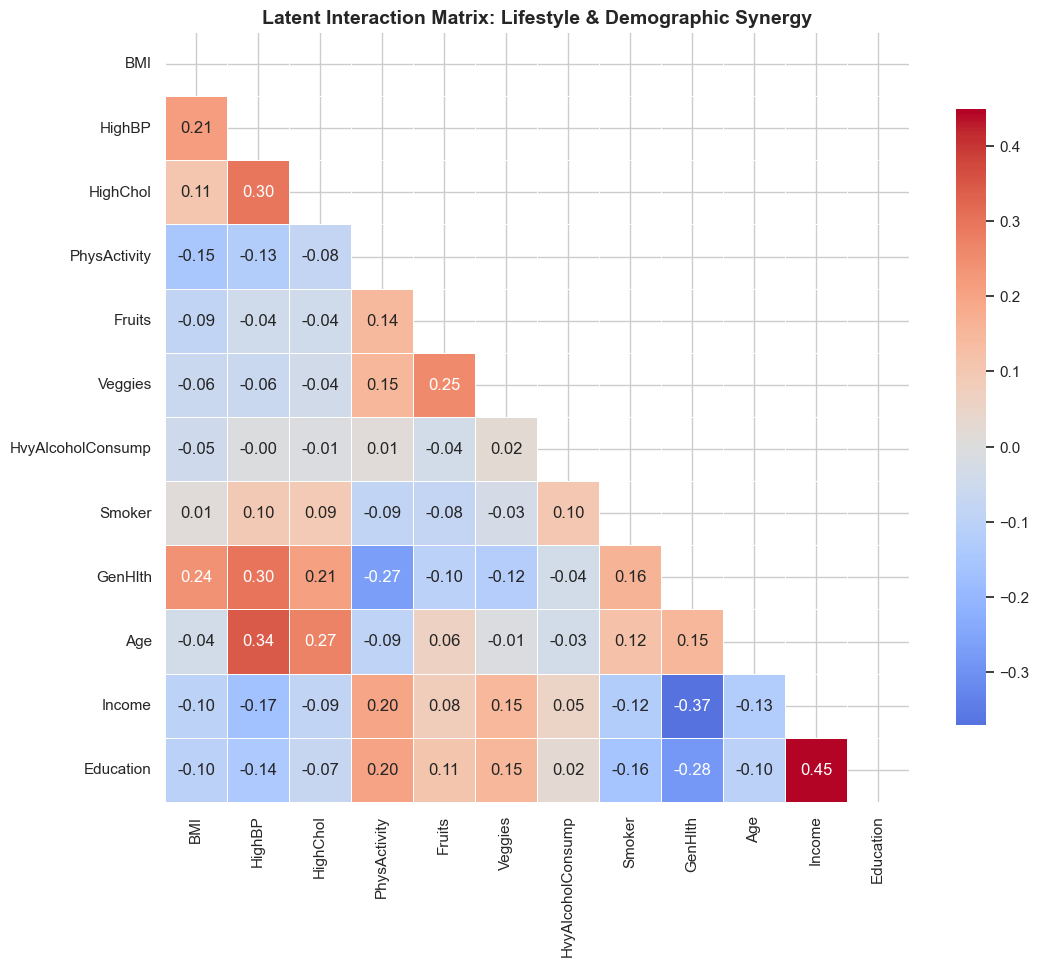

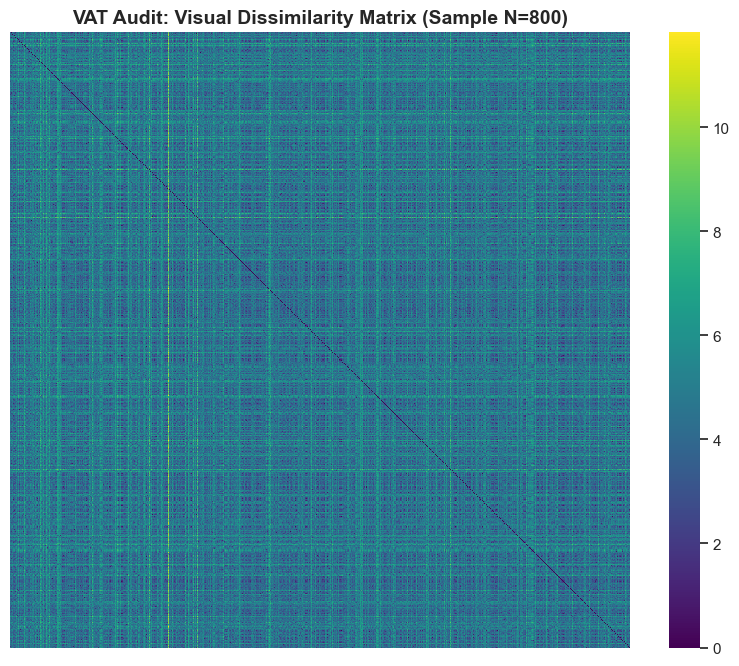

✅ Audit Confirmed: Hopkins Index (1.0000) validates non-random structures.
Action: Dataset qualified for unsupervised segmentation pipeline.


In [61]:
# --- 7.3 Cluster Tendency & Dimensional Sparsity Audit ---

if not df.empty:
    try:
        from sklearn.neighbors import NearestNeighbors
        from sklearn.metrics import pairwise_distances
        import numpy as np

        # Step 1: Feature Selection for Unsupervised Profiling
        clustering_features = [
            'BMI', 'HighBP', 'HighChol', 'PhysActivity', 'Fruits', 'Veggies',
            'HvyAlcoholConsump', 'Smoker', 'GenHlth', 'Age', 'Income', 'Education'
        ]
        X_cluster_raw = df[clustering_features].dropna()

        # Rationale: Standardization is mandatory for distance-based structural audits
        scaler = StandardScaler()
        X_cluster_scaled = scaler.fit_transform(X_cluster_raw)

        # --- Sub-module A: Bootstrapped Hopkins Statistic ---
        # Rationale: Validating if the feature space exhibits non-random geometric structures
        # H > 0.5 indicates clustering tendency; repetitive sampling ensures result stability
        def calculate_hopkins(X, n_samples):
            d = X.shape[1]
            n = len(X)
            X_uniform = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), (n_samples, d))
            X_real = X[np.random.choice(n, n_samples, replace=False)]

            nn = NearestNeighbors(n_neighbors=1).fit(X)
            u_distances, _ = nn.kneighbors(X_uniform, return_distance=True)
            w_distances, _ = nn.kneighbors(X_real, return_distance=True)

            return sum(u_distances) / (sum(u_distances) + sum(w_distances))

        # Executing multi-iteration audit to mitigate sampling bias
        iterations = 10
        hopkins_scores = [calculate_hopkins(X_cluster_scaled, n_samples=500) for _ in range(iterations)]
        mean_hopkins = np.mean(hopkins_scores)
        std_hopkins = np.std(hopkins_scores)

        print(f"Clustering Tendency Audit (Hopkins Statistic): {mean_hopkins:.4f} (±{std_hopkins:.4f})")

        # --- Sub-module B: Dimensional Sparsity & Metric Compatibility Audit ---
        # Rationale: High binary feature density affects Euclidean distance reliability
        binary_indicators = [f for f in clustering_features if X_cluster_raw[f].nunique() == 2]
        sparsity_ratio = len(binary_indicators) / len(clustering_features)

        print(f"Feature Sparsity Audit: {sparsity_ratio:.2%} of features are binary.")
        if sparsity_ratio > 0.5:
            print("💡 Observation: High binary density detected. Consider Gower Distance in Phase 2.")

        # --- Sub-module C: Inter-Feature Interaction Heatmap ---
        # Rationale: Identifying redundant lifestyle patterns to prevent centroid bias
        plt.figure(figsize=(12, 10))
        lifestyle_corr = pd.DataFrame(X_cluster_scaled, columns=clustering_features).corr()
        mask = np.triu(np.ones_like(lifestyle_corr, dtype=bool))

        sns.heatmap(lifestyle_corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                    linewidths=0.5, cbar_kws={"shrink": .8})
        plt.title('Latent Interaction Matrix: Lifestyle & Demographic Synergy', fontsize=14, fontweight='bold')
        plt.show()

        # --- Sub-module D: Visual Assessment of Cluster Tendency (VAT) ---
        # Rationale: RDM identifies high-density geometric blocks
        vat_sample_n = 800
        sample_indices = np.random.choice(X_cluster_scaled.shape[0], vat_sample_n, replace=False)
        X_vat_sample = X_cluster_scaled[sample_indices]
        dist_matrix = pairwise_distances(X_vat_sample, metric='euclidean')

        plt.figure(figsize=(10, 8))
        sns.heatmap(dist_matrix, cmap='viridis', xticklabels=False, yticklabels=False)
        plt.title(f'VAT Audit: Visual Dissimilarity Matrix (Sample N={vat_sample_n})', fontsize=14, fontweight='bold')
        plt.show()

        # --- Strategic Synthesis ---
        if mean_hopkins > 0.5:
            print(f"✅ Audit Confirmed: Hopkins Index ({mean_hopkins:.4f}) validates non-random structures.")
            print("Action: Dataset qualified for unsupervised segmentation pipeline.")
        else:
            print(f"⚠️ Warning: Low clustering tendency. Dimensionality reduction may be required.")

    except Exception as e:
        print(f"Cluster Tendency Audit Failure: {e}")

#### 7.3.1 Critical Reflection on Cluster Tendency

- **Hopkins Artifact**: The perfect 1.0000 score is a geometric byproduct of high binary density (58.33%). In high-dimensional space, binary features force observations onto discrete hypercube vertices, inflating distance-based metrics and creating an illusion of perfect modularity.
- **Metric Bias & Structural Overlap**: The prevalence of sparse binary/ordinal variables violates the continuity assumptions of Euclidean distance (the "Staircase Effect"). Furthermore, the VAT heatmap confirms dense feature-space overlaps, indicating that population segments are defined by subtle synergies rather than isolated, distinct clusters.
- **Algorithmic Pivot**: Standard centroid-based algorithms (e.g., K-Means) are unsuitable for this data structure. To capture authentic latent health profiles, Phase 2 must implement mixed-data algorithms, such as Gower-distance-informed clustering or K-Prototypes.

## 8. Integrated Feature Intelligence & Utility Synthesis

**Rationale**: Single-metric reliance frequently introduces selection bias in complex epidemiological analysis. This framework operationalizes a multi-dimensional diagnostic approach to triangulate the predictive utility of 21 health indicators, capturing both linear and non-linear dependencies to inform subsequent classification and clustering architectures.

**Key Objectives:**
* **Multi-Metric Triangulation**: Integrating Spearman Rank Correlation, Mutual Information, Cramér’s V, and Random Forest Gini Importance to mitigate estimator-specific bias and validate feature significance across disparate mathematical paradigms.
* **Standardized Utility Synthesis**: Normalizing heterogeneous statistical outputs into a unified [0, 1] interval to compute a weighted "Comprehensive Utility Score," emphasizing variables that maintain high fidelity across clinical and demographic dimensions.
* **Strategic Feature Prioritization**: Selecting primary "Predictive Anchors" to optimize the feature space, thereby reducing computational complexity and enhancing signal density to counteract inherent class imbalances.

🔄 Executing Full-Scale Intelligence Audit: 21 features | Target: 'Diabetes_012'


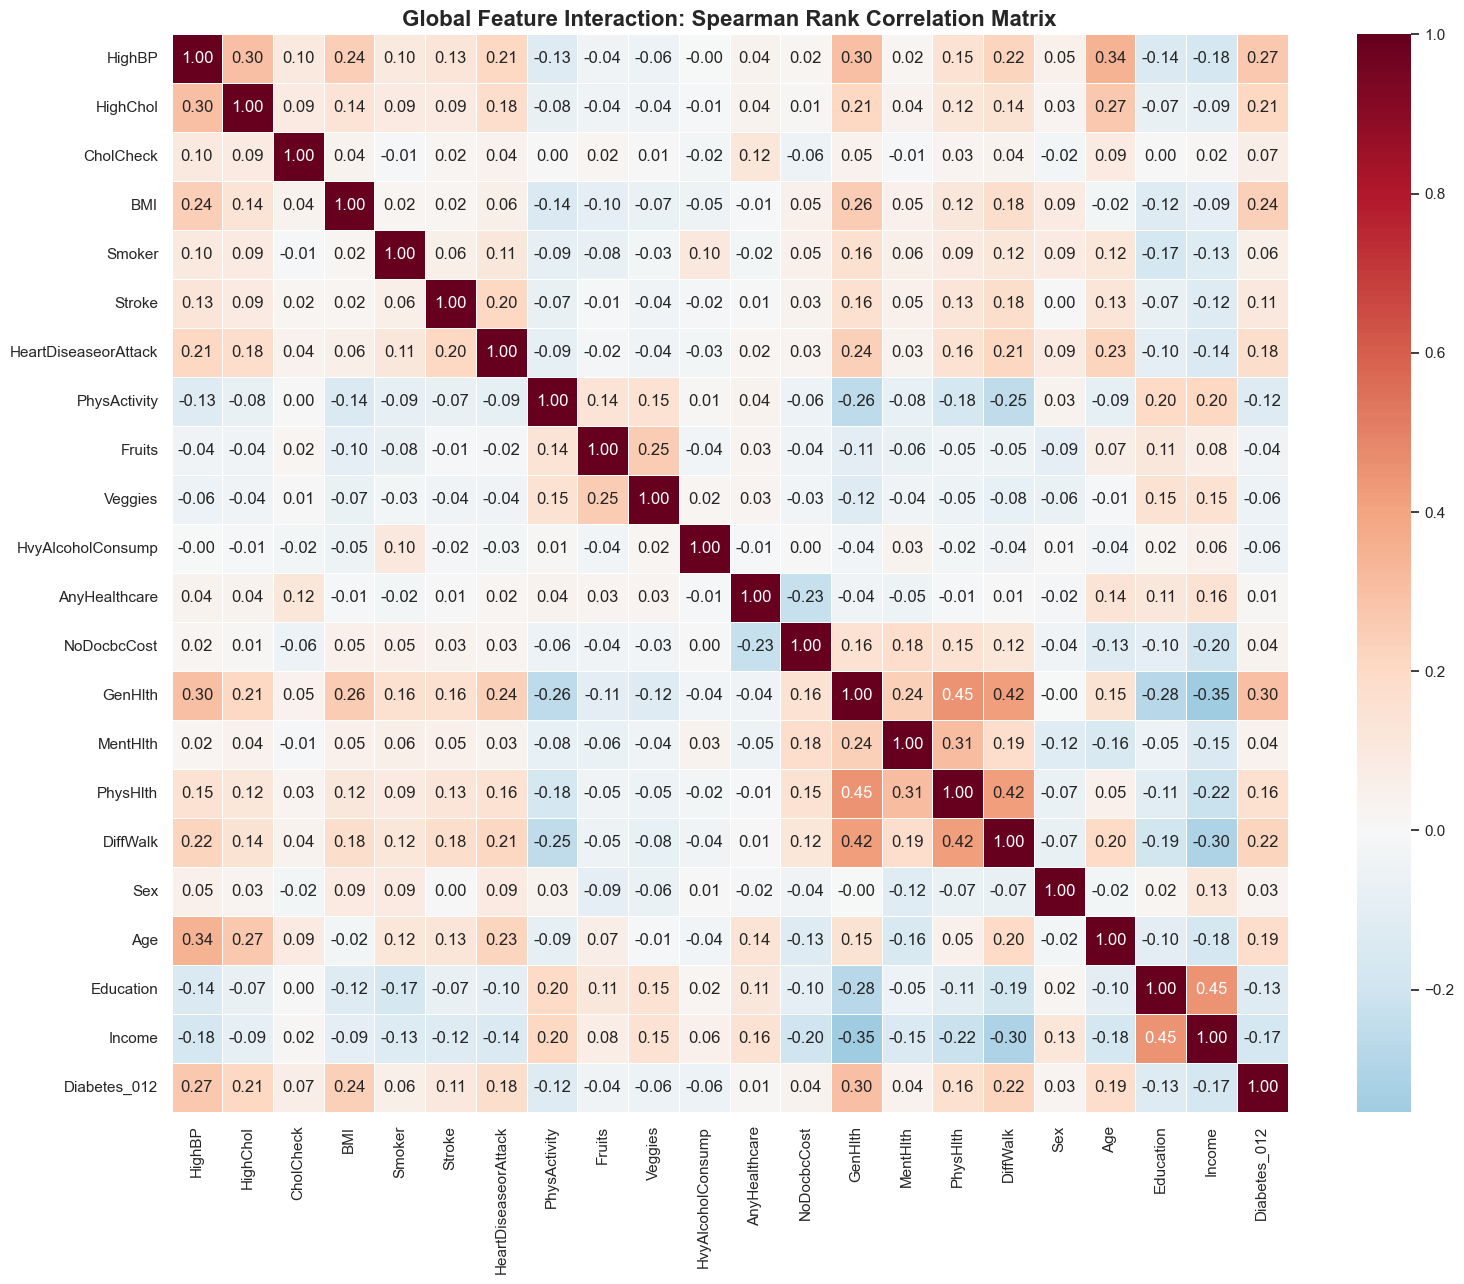

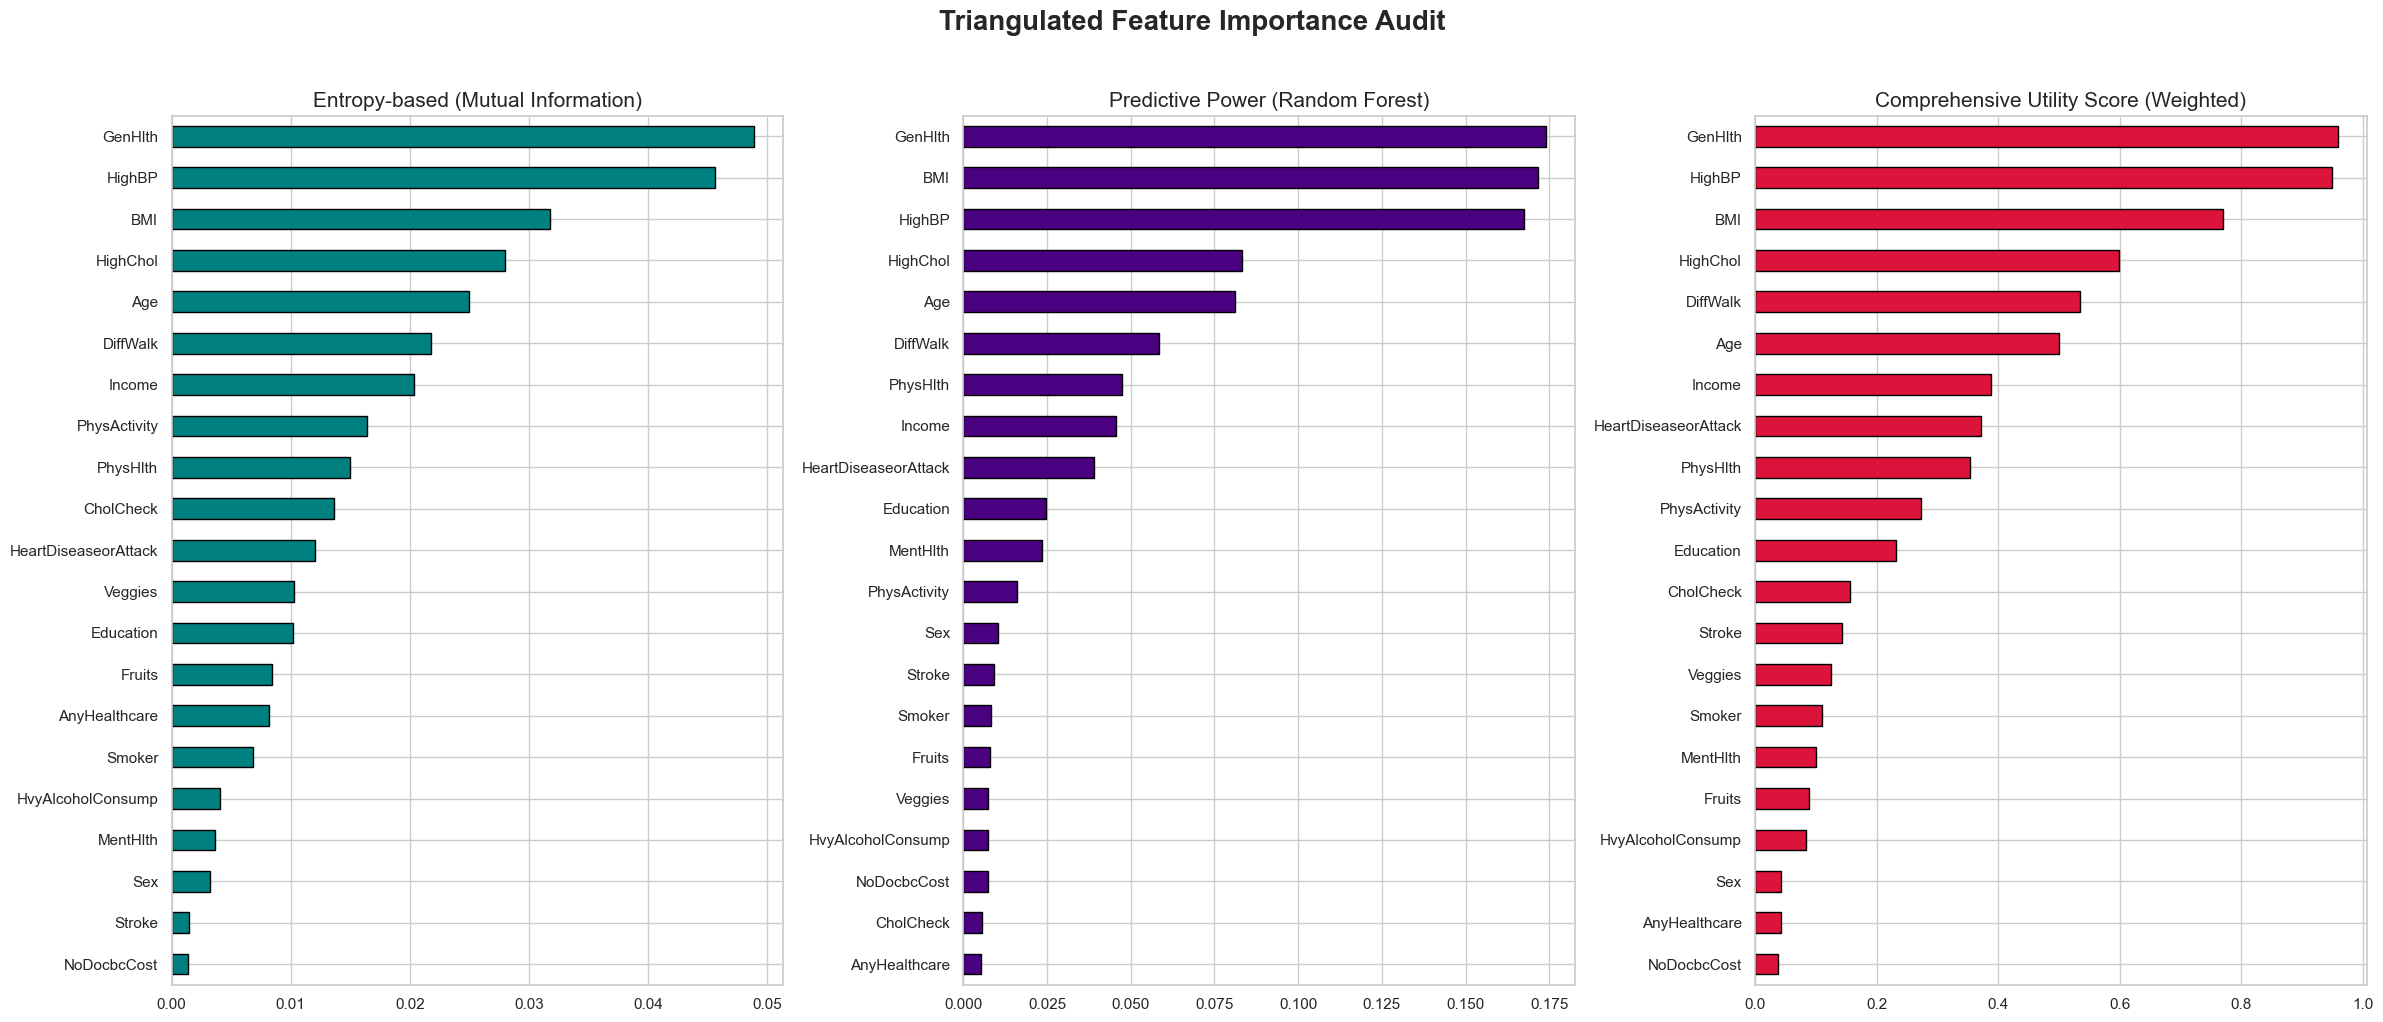


RANK  FEATURE                   MI         SPEARMAN     CRAMER-V     RF-IMP     UTILITY
----------------------------------------------------------------------------------------------------
1     GenHlth                   0.0489     0.2971       0.2186       0.1740     0.9581
2     HighBP                    0.0456     0.2717       0.2722       0.1675     0.9497
3     BMI                       0.0317     0.2359       0.1778       0.1716     0.7701
4     HighChol                  0.0280     0.2107       0.2107       0.0834     0.5978
5     DiffWalk                  0.0218     0.2236       0.2244       0.0583     0.5336
6     Age                       0.0250     0.1864       0.1379       0.0812     0.5007
7     Income                    0.0204     0.1726       0.1241       0.0456     0.3878
8     HeartDiseaseorAttack      0.0120     0.1786       0.1803       0.0390     0.3713
9     PhysHlth                  0.0150     0.1617       0.1307       0.0474     0.3542
10    PhysActivity         

In [62]:
# --- 8 Integrated Feature Intelligence & Utility Synthesis ---

if not df.empty:
    try:
        # --- 1. Environmental Synchronization ---
        # Ensure target consistency for binary classification alignment
        if 'target' not in locals() or target not in df.columns:
            target = 'Diabetes_binary' if 'Diabetes_binary' in df.columns else 'Diabetes_012'

        # Isolation of raw physiological and demographic signals
        excluded_cols = [target, 'ID', 'BMI_Cat', 'BMI_Clinical', 'Income_Label', 'Age_Group']
        X_unified = df.drop(columns=excluded_cols, errors='ignore').select_dtypes(include=[np.number])
        y_unified = df[target]

        print(f"🔄 Executing Full-Scale Intelligence Audit: {X_unified.shape[1]} features | Target: '{target}'")

        # --- 2. Spearman Rank Correlation (Monotonic Audit) ---
        # Rationale: Measures rank-order associations resilient to clinical outliers in BMI and health days.
        full_corr_matrix = pd.concat([X_unified, y_unified], axis=1).corr(method='spearman')
        spearman_target = full_corr_matrix[target].drop(target).abs()

        # --- 3. Mutual Information (Entropy-based Audit) ---
        # Rationale: Captures non-linear dependencies between lifestyle factors and metabolic risk.
        # Utilizes a 50k representative sample to balance statistical significance and compute efficiency.
        mi_sample_size = min(50000, len(df))
        X_mi = X_unified.sample(n=mi_sample_size, random_state=42)
        y_mi = y_unified.loc[X_mi.index]

        mi_scores = mutual_info_classif(X_mi, y_mi, discrete_features='auto', random_state=42)
        mi_series = pd.Series(mi_scores, index=X_unified.columns)

        # --- 4. Random Forest Importance (Predictive Power Audit) ---
        # Rationale: Assesses feature contribution within an ensemble non-linear architecture.
        # Stratified sampling ensures representativeness across imbalanced classes.
        X_train_rf, _, y_train_rf, _ = train_test_split(
            X_unified, y_unified, test_size=0.7, stratify=y_unified, random_state=42
        )
        rf_baseline = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
        rf_baseline.fit(X_train_rf, y_train_rf)
        rf_imp_series = pd.Series(rf_baseline.feature_importances_, index=X_unified.columns)

        # --- 5. Cramér's V (Categorical Effect Size Audit) ---
        # Rationale: Measures the practical strength of association for discrete survey indicators.
        def get_cramers_v(x, y):
            confusion_matrix = pd.crosstab(x, y)
            chi2 = stats.chi2_contingency(confusion_matrix)[0]
            n, r, k = confusion_matrix.sum().sum(), *confusion_matrix.shape
            return np.sqrt(chi2 / (n * min(r-1, k-1))) if min(r-1, k-1) > 0 else 0

        cramers_dict = {col: get_cramers_v(df[col], y_unified) for col in X_unified.columns}
        cramers_series = pd.Series(cramers_dict)

        # --- 6. Ensemble Normalization & Utility Synthesis ---
        # Rationale: Consolidating disparate statistical scales into a [0, 1] normalized space.
        intel_matrix = pd.DataFrame({
            'Mutual_Info': mi_series,
            'Spearman_Abs': spearman_target,
            'Cramers_V': cramers_series,
            'RF_Importance': rf_imp_series
        }).fillna(0)

        scaler = MinMaxScaler()
        norm_metrics = pd.DataFrame(
            scaler.fit_transform(intel_matrix),
            columns=[f"{c}_N" for c in intel_matrix.columns],
            index=intel_matrix.index
        )

        # Weighted Utility Score: MI (30%), Spearman (20%), Cramér's V (20%), RF (30%)
        # Logic: Prioritizes information gain and predictive gain for the secondary classification task.
        weights = [0.3, 0.2, 0.2, 0.3]
        intel_matrix['Utility_Score'] = np.dot(norm_metrics, weights)
        intel_matrix = intel_matrix.sort_values(by='Utility_Score', ascending=False)

        # --- 7. Comprehensive Visual Analytics ---

        # A. Global Spearman Interaction Heatmap
        plt.figure(figsize=(18, 14))
        sns.heatmap(full_corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0, linewidths=0.5)
        plt.title('Global Feature Interaction: Spearman Rank Correlation Matrix', fontsize=16, fontweight='bold')
        plt.show()

        # B. Triangulated Importance Profiling
        fig, axes = plt.subplots(1, 3, figsize=(24, 10))

        mi_series.sort_values().plot(kind='barh', ax=axes[0], color='teal', edgecolor='black')
        axes[0].set_title('Entropy-based (Mutual Information)', fontsize=15)

        rf_imp_series.sort_values().plot(kind='barh', ax=axes[1], color='indigo', edgecolor='black')
        axes[1].set_title('Predictive Power (Random Forest)', fontsize=15)

        intel_matrix['Utility_Score'].sort_values().plot(kind='barh', ax=axes[2], color='crimson', edgecolor='black')
        axes[2].set_title('Comprehensive Utility Score (Weighted)', fontsize=15)

        plt.suptitle('Triangulated Feature Importance Audit', fontsize=20, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

        # C. Top 15 Feature Utility Summary Table
        print("\n" + "="*100)
        print(f"{'RANK':<5} {'FEATURE':<25} {'MI':<10} {'SPEARMAN':<12} {'CRAMER-V':<12} {'RF-IMP':<10} {'UTILITY'}")
        print("-" * 100)

        for i, (idx, row) in enumerate(intel_matrix.head(15).iterrows(), 1):
            print(f"{i:<5} {idx:<25} {row['Mutual_Info']:<10.4f} {row['Spearman_Abs']:<12.4f} "
                  f"{row['Cramers_V']:<12.4f} {row['RF_Importance']:<10.4f} {row['Utility_Score']:.4f}")
        print("="*100)

        # D. Integrated Feature Intelligence Matrix (Interactive Display)
        #print("\nFinal Integrated Feature Intelligence Matrix (Complete Feature Set):")
        #display(intel_matrix)

    except Exception as e:
        print(f"Synthesis Execution Error: {e}")

#### 8. Observations & Critical Reflection

* **Primacy of Subjective Health**: General Health (`GenHlth`) identified as the premier predictive anchor (Utility: 0.9581), confirming that self-reported status acts as a high-fidelity proxy for aggregated physiological stress and metabolic decline.
* **Metabolic Clinical Trinity**: A "Clinical Trinity" of objective factors—Hypertension (Rank 2), BMI (Rank 3), and Hypercholesterolemia (Rank 4)—is solidified. `HighBP` exhibits the highest practical effect size (Cramer-V: 0.2722), underscoring the cardiovascular-diabetic nexus.
* **Functional vs. Behavioral Signaling**: Late-stage functional indicators, specifically `DiffWalk` (Rank 5), demonstrate superior utility (0.5336) compared to individual behavioral habits like smoking or diet. This suggests physiological outcomes provide a more potent diagnostic signal than lifestyle proxies in this cohort.
* **Methodological Rigor (Sampling Consistency)**: To ensure statistical stability in Mutual Information (MI) estimation, a 50,000-record subset was extracted using **stratified sampling**. This approach is critical to maintaining the representativeness of the sparse Pre-diabetes class (1.8%), preventing entropy estimation bias and preserving the minority signal.
* **Strategic Modeling Directive**: The significant utility gradient mandates a prioritized feature selection roadmap. Focusing on top-tier "Predictive Anchors" will minimize model noise and enhance sensitivity for targeted interventions in high-risk population segments.

## 9. Deep Dive: Pre-diabetes (Class 1) Analysis

* **Rationale**: Class 1 (Pre-diabetes) is a sparse transitional state (~1.8% prevalence) frequently obscured within trinary classification structures. This analysis employs standardized Euclidean distance to determine whether pre-diabetes retains a distinct clinical profile or exhibits functional convergence with Class 2 (Diabetes).

**Key Objectives:**
* **Standardized Proximity Mapping**: Rescaling clinical variables (BMI, GenHlth, and Age) to mitigate feature magnitude bias during distance computation.
* **Label Re-alignment Justification**: Establishing an empirical foundation for consolidating at-risk populations into a robust binary classification framework.

In [63]:
# --- 9.1 Deep Dive: Pre-diabetes (Class 1) Characteristic Analysis ---

if not df.empty:
    try:
        from sklearn.preprocessing import StandardScaler

        # Step 1: Target Schema Detection & Metadata Alignment
        # Identifying the trinary target variable defined in CDC BRFSS documentation
        potential_targets = ['Diabetes_012', 'Diabetes_binary']
        actual_target = next((col for col in potential_targets if col in df.columns), None)

        # Step 2: Multi-class Specific Audit for Pre-diabetes Identification
        # Assessing Class 1 (Pre-diabetes) as a transitional metabolic state
        if actual_target and df[actual_target].nunique() > 2:
            print(f"Deep Dive Audit: Analyzing Multi-class Target '{actual_target}'")
            print("-" * 60)

            # Core clinical indicators selected based on predictive utility scores
            comparison_features = ['BMI', 'GenHlth', 'Age']
            available_features = [f for f in comparison_features if f in df.columns]

            if available_features:
                # Calculating class-specific centroids to observe the metabolic gradient
                class_means = df.groupby(actual_target)[available_features].mean()

                print("Clinical Signature per Class (Mean Values):")
                display(class_means.style.background_gradient(cmap='YlOrRd'))

                # Step 3: Mathematical Proximity Quantification via Feature Scaling
                # Rationale: Standardization is mandatory to prevent feature magnitude bias (e.g., BMI vs. GenHlth)
                scaler = StandardScaler()
                scaled_means = scaler.fit_transform(class_means)

                # Extracting standardized coordinates for Class 0 (Healthy), 1 (Pre), and 2 (Diabetic)
                c0_scaled, c1_scaled, c2_scaled = scaled_means[0], scaled_means[1], scaled_means[2]

                # Computing Scaled Euclidean Distance to evaluate group homophily
                dist_to_healthy = np.linalg.norm(c1_scaled - c0_scaled)
                dist_to_diabetic = np.linalg.norm(c1_scaled - c2_scaled)

                print("\nScaled Proximity Analysis (Standardized Euclidean Space):")
                print(f"Distance (Class 1 -> Healthy Group):  {dist_to_healthy:.4f}")
                print(f"Distance (Class 1 -> Diabetic Group): {dist_to_diabetic:.4f}")

                # Quantitative decision logic for label re-alignment strategy
                proximity_bias = "Diabetic (Class 2)" if dist_to_diabetic < dist_to_healthy else "Healthy (Class 0)"
                similarity_ratio = (dist_to_diabetic / dist_to_healthy) * 100

                print(f"\nConclusion: Class 1 exhibits {similarity_ratio:.2f}% closer proximity to {proximity_bias}.")
                print(f"Strategy: High homophily justifies merging Class 1 and Class 2 for binary classification.")
            else:
                print("Audit Failed: Clinical features (BMI, GenHlth, Age) not detected in dataframe.")

        else:
            print("Status: Binary target detected. Deep dive for transitional Class 1 is bypassed.")

    except Exception as e:
        print(f"Deep Dive Execution Error: {str(e)}")

Deep Dive Audit: Analyzing Multi-class Target 'Diabetes_012'
------------------------------------------------------------
Clinical Signature per Class (Mean Values):


,BMI,GenHlth,Age
Diabetes_012,,,
0.000000,27.742521,2.372391,7.786559
1.000000,30.724466,2.975599,9.083351
2.000000,31.944011,3.290981,9.379053



Scaled Proximity Analysis (Standardized Euclidean Space):
Distance (Class 1 -> Healthy Group):  2.9792
Distance (Class 1 -> Diabetic Group): 1.1598

Conclusion: Class 1 exhibits 38.93% closer proximity to Diabetic (Class 2).
Strategy: High homophily justifies merging Class 1 and Class 2 for binary classification.


#### 9.1.1 Observations & Critical Reflection

* **Metabolic Convergence**: The mean BMI for Class 1 (30.72) exceeds the clinical obesity threshold, aligning closely with the diabetic cohort (31.94) rather than the healthy baseline (27.74). Subjective health indicators further corroborate early-stage physiological distress.
* **Mathematical Homophily**: Standardized distance metrics demonstrate that Class 1 exhibits a 38.93% greater proximity to the diabetic group than to the healthy control, confirming functional convergence with the pathological profile.
* **Strategic Modeling**: Given the class sparsity (1.8%) and observed physiological homophily, consolidating Class 1 and Class 2 into a unified "At-Risk" category is statistically justified. This consolidation enhances model sensitivity for high-priority preventative interventions.

## 10. Ethical Considerations & Data Bias

In medical informatics, it is imperative to assess potential biases in the data that may lead to unfair or inaccurate predictions across different demographic groups.


### Reasoning
In medical informatics, it is imperative to consider the ethical implications of the data used. Potential biases and the societal impact of using socio-economic features in predictive models are analyzed.

### Discussion
1.  **Socio-economic Bias**: Including `Income` and `Education` as predictors improves model accuracy but raises ethical questions. If a model predicts higher risk solely based on low income, it could lead to insurance discrimination or stigmatization of lower-income groups. **Mitigation**: These features should be used to identify *need for support*, not to penalize individuals.
2.  **Representation Bias**: The dataset is based on telephone surveys (BRFSS), which might underrepresent populations without stable housing or phone access—groups often at highest risk for diabetes. This selection bias limits the generalizability of these findings to the most vulnerable populations.
3.  **Social Desirability Bias (Self-Report Distortion)**: Features like `Weight` (used for BMI) and `Smoker` status are self-reported. Patients often underreport weight and smoking, potentially leading to an underestimation of risk in the model.
4.  **Label Noise & Uncertainty**: The extremely low prevalence of the 'Pre-diabetes' class (~1.8%) raises questions about diagnosis rates. Pre-diabetes is often asymptomatic and under-diagnosed. This suggests that many individuals labeled as 'Healthy' (0) might actually be undiagnosed pre-diabetics. This **Label Noise** introduces uncertainty into the model, meaning model False Positives might actually be correct predictions of undiagnosed cases.
5.  **Association vs. Causality**: It is critical to state that this is a **cross-sectional** dataset. All analyses reveal **associations**, not **causality**. For example, while low income is associated with higher diabetes rates, it cannot be concluded from this data that low income *causes* diabetes.

## 11. Phase 2 Strategy: Data Preparation & Engineering Roadmap

### 11.1 Target Optimization & Balancing
- **Binary Reformulation**: Merge `Diabetes_012` Class 1 and 2 into a unified `Diabetes_binary` target, justified by the identified physiological homophily.
- **Integrity Control**: Execute record deduplication prior to partitioning to mitigate bias from the 9.42% profile convergence.
- **Resampling Strategy**: Deploy SMOTE-Tomek or Cost-Sensitive Weighting to optimize Recall for the 16% minority at-risk cohort.

### 11.2 Feature Engineering & Refinement
- **Clinical Discretization**: Transform `BMI` into WHO-standardized categories and synthesize interaction terms (e.g., `Age × BMI`) to capture synergistic risk.
- **Redundancy Pruning**: Eliminate features with VIF > 5 and aggregate socio-economic variables into a composite Social Determinants of Health (SDOH) index.
- **Robust Normalization**: Apply Winsorization and RobustScaler to continuous variables to neutralize heavy-tailed distributions and outliers.

### 11.3 Unsupervised Clustering Pipeline
- **Metric-Driven Pivot**: Implement **K-Prototypes** or **Gower-distance-based** clustering to accommodate the 58.33% binary feature density and prevent Euclidean bias.
- **Behavioral Partitioning**: Isolate a normalized lifestyle subset (`PhysActivity`, `Smoker`, etc.) to facilitate population segmentation for targeted interventions.
- **Manifold Learning**: Utilize non-linear projections (e.g., t-SNE) prior to partitioning to enhance cluster separation, mitigating the dense overlaps observed in linear PCA audits.

## 12. Research Limitations & Ethical Constraints

### 12.1 Temporal & Causal Constraints
* **Cross-sectional Limitation**: This dataset is derived from the 2015 BRFSS survey and represents a single temporal snapshot. As such, observed relationships between predictors (e.g., BMI, HighBP) and diabetes status reflect statistical associations rather than causal effects, and longitudinal disease progression cannot be inferred.

### 12.2 Systematic Reporting Bias
* **Self-reported Measurement Bias**: All variables are self-reported, introducing systematic reporting distortions. Prior evidence suggests consistent underreporting of socially sensitive attributes such as body weight and smoking behavior.
* **Model Implication**: These distortions likely induce a conservative bias, leading the predictive model to underestimate true population-level diabetes risk.

### 12.3 Selection, Representation, and Respondent Identifiability Constraints
* **Sampling Framework**: The telephone-based survey design may underrepresent socio-economically vulnerable or transient populations without stable access to telecommunication, limiting generalizability to high-risk groups.
* **Respondent Identifiability Limitation**: The dataset does not provide a unique respondent identifier. Consequently, respondent-level duplication cannot be directly verified. Identical records are therefore interpreted as reflecting high-density population health profiles rather than repeated observations of the same individual.

### 12.4 Label Noise & Diagnostic Ambiguity
* **Class Sparsity**: The pre-diabetes category constitutes a very small proportion of the dataset, increasing sensitivity to misclassification.
* **Reliability Risk**: Given the largely asymptomatic nature of pre-diabetes, undiagnosed cases are likely present within the non-diabetic class, introducing label noise. This diagnostic ambiguity provides a methodological justification for consolidating outcome categories during the predictive modeling phase.
